# Detección de biomarcadores de autismo utilizando Aprendizaje Automático

### Librerías y carga de archivos

In [ ]:
# @title Instalación librería Nilearn
!pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 50.6 MB/s eta 0:00:00


# Setup y paths

In [ ]:
# Librerías utilizadas en este trabajo

import os
import io
import glob
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import glob
import argparse
#import nilearn

In [ ]:
# Conexión con Google Drive para acceder a los repositorios con los archivos

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ruta de acceso a los archivos
path_data = "/content/drive/MyDrive/Favaloro/Tesis/ABIDE/time_series"
path_ABIDE = "/content/drive/MyDrive/Favaloro/Tesis/ABIDE"

In [ ]:
# Ruta de acceso a las coordenadasde las  ROIs
coords = pd.read_csv(os.path.join(path_ABIDE, "rois_coordinates.csv"))

# labels ROIs
#rois = np.loadtxt(os.path.join(path_ABIDE, "rois_labels.txt"), dtype="str")

# Ruta de acceso a los metadatos  (AUTISTA/CONTROL)
metadata = pd.read_csv(os.path.join(path_ABIDE, "metadata.csv"))

# Ruta de acceso al archivo nii
nii_path = "/content/drive/MyDrive/Favaloro/Tesis/ABIDE/AAL2.nii"

# Ruta de acceso al atlas AAL2
path_atlas = "/content/drive/MyDrive/Favaloro/Tesis/ABIDE/AAL2_94rois.nii.gz"

In [ ]:
# Daraframe guardado con los vectores de las correlaciones de las series temporales
df = pd.read_csv('/content/drive/MyDrive/Favaloro/Tesis/vectores.csv')

In [ ]:
df_pc = pd.read_csv('/content/drive/MyDrive/Favaloro/Tesis/df_pc.csv')

# Clasificadores

In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4362,4363,4364,4365,4366,4367,4368,4369,4370,condicion
0,0.884496,0.709854,0.759467,0.808396,0.748825,0.746855,0.797611,0.754630,0.699556,0.558432,...,0.894507,0.848783,0.875080,0.853000,0.754495,0.673811,0.807199,0.812130,0.915447,1
1,0.913155,0.508644,0.210797,0.375724,0.136328,0.550674,0.217562,0.446146,0.257435,0.336017,...,0.552078,0.645986,0.629501,0.814782,0.648253,0.585712,0.574145,0.465562,0.773946,0
2,0.693080,0.639012,0.427046,0.553249,0.370843,0.639087,0.615761,0.474038,0.523910,0.360967,...,0.697781,0.573982,0.727019,0.648158,0.601135,0.471724,0.460433,0.525508,0.854126,1
3,0.674283,0.356046,0.395826,0.250278,0.315492,0.327619,0.418142,0.318003,0.344895,0.407478,...,0.762027,0.589437,0.729525,0.827515,0.567599,0.546411,0.680090,0.719204,0.798524,0
4,0.631215,0.468764,0.447137,0.464821,0.383575,0.549706,0.380909,0.574176,0.417614,0.567322,...,0.634173,0.671634,0.658479,0.599554,0.443173,0.456866,0.421308,0.572873,0.629786,0


In [ ]:
# Por convención
# Controles = cero: 0
# Autistas = uno: 1

df["condicion"] = df["condicion"].replace("CONT", 0)

df["condicion"] = df["condicion"].replace("AUT", 1)

In [ ]:
features = df.drop(['condicion'], axis=1)
condicion = df['condicion'].values
features.shape

(973, 4371)

In [ ]:
# División de los datos en conjuntos de entrenamiento y prueba

from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(features, condicion, stratify = condicion, test_size=0.25)
# Stratify balancea la cantidad de sujetos de cada condicion en la división de os datos

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (729, 4371)
X_test: (244, 4371)
y_train: (729,)
y_test: (244,)


In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.under_sampling import NearMiss
from collections import Counter
from sklearn.datasets import make_classification



print("Distribución original de clases: {}".format(Counter(y_train)))

# Aplicar NearMiss
nm = NearMiss(version=1, n_neighbors=3)
X_train_res, y_train_res = nm.fit_resample(X_train, y_train)

print("Distribución después del resampling: {}".format(Counter(y_train_res)))

# Continuar con el entrenamiento del modelo usando X_train_res, y_train_res

Distribución original de clases: Counter({0: 443, 1: 286})
Distribución después del resampling: Counter({0: 286, 1: 286})


In [ ]:
# Porcentaje de autistas en el conjunto de entrenamiento
porcentaje_autistas_train = (y_train == 1).sum() / len(y_train) * 100

# Porcentaje de autistas en el conjunto de entrenamiento
porcentaje_ytrain_res = (y_train == 1).sum() / len(y_train_res) * 100
porcentaje_xtrain_res = (y_train == 1).sum() / len(X_train_res) * 100

# Porcentaje de controles en el conjunto de entrenamiento
porcentaje_controles_train = (y_train == 0).sum() / len(y_train) * 100

# Porcentaje de autistas en el conjunto de prueba
porcentaje_autistas_test = (y_test == 1).sum() / len(y_test) * 100

# Porcentaje de controles en el conjunto de prueba
porcentaje_controles_test = (y_test == 0).sum() / len(y_test) * 100



print(f'Porcentaje de autistas en el conjunto de entrenamiento: {porcentaje_autistas_train:.2f}%')
print(f'Porcentaje de controles en el conjunto de entrenamiento: {porcentaje_controles_train:.2f}%')
print(f'Porcentaje de autistas en el conjunto de prueba: {porcentaje_autistas_test:.2f}%')
print(f'Porcentaje de controles en el conjunto de prueba: {porcentaje_controles_test:.2f}%')
print(porcentaje_ytrain_res)
print(porcentaje_xtrain_res)


Porcentaje de autistas en el conjunto de entrenamiento: 39.23%
Porcentaje de controles en el conjunto de entrenamiento: 60.77%
Porcentaje de autistas en el conjunto de prueba: 39.34%
Porcentaje de controles en el conjunto de prueba: 60.66%
50.0
50.0


# Clasificadores

**Máquinas de Vectores de Soportes**

In [ ]:
# Define the hyperparameter grid to explore
param_grid = {'C': [0.0001, 0.1, 1, 10,100], 'degree': [1,2,3,5,8,10], 'gamma': ['auto','scale'],'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
svm = SVC()


# hyp tunning con gridsearch
grid_search = GridSearchCV(svm, param_grid, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True)


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
{'Model': SVC(C=0.1, kernel='poly'), 'Best Params': {'C': 0.1, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}, 'Accuracy': 0.7064052905054322, 'Classification Report': {'AUT': {'precision': 0.68125, 'recall': 0.7364864864864865, 'f1-score': 0.7077922077922078, 'support': 148}, 'CONT': {'precision': 0.5357142857142857, 'recall': 0.46875, 'f1-score': 0.5, 'support': 96}, 'accuracy': 0.6311475409836066, 'macro avg': {'precision': 0.6084821428571429, 'recall': 0.6026182432432432, 'f1-score': 0.6038961038961039, 'support': 244}, 'weighted avg': {'precision': 0.6239900468384075, 'recall': 0.6311475409836066, 'f1-score': 0.6260378965296998, 'support': 244}}}


[[109  39]
 [ 51  45]]


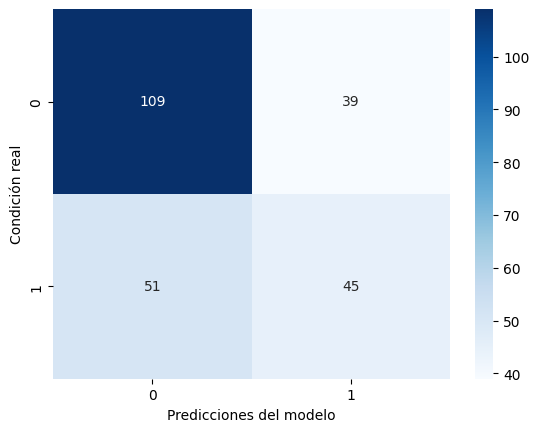

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.show()

**Bósques Aleatorios**

In [ ]:
param_grid_RF = {'n_estimators': [1000], 'max_depth': [5,20,None] }

In [ ]:
y_train = y_train.astype(float)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

RF = RandomForestClassifier()

# hyp tunning con gridsearch
grid_search = GridSearchCV(RF, param_grid_RF, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True) # la función usa las etiquetas de clase reales (0 y 1) para calcular las métricas, y el parámetro target_names solo se usa con fines de visualización.


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
#resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
#resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'Model': RandomForestClassifier(n_estimators=1000), 'Best Params': {'max_depth': None, 'n_estimators': 1000}, 'Accuracy': 0.67764761454889, 'Classification Report': {'AUT': {'precision': 0.6538461538461539, 'recall': 0.8040540540540541, 'f1-score': 0.7212121212121212, 'support': 148}, 'CONT': {'precision': 0.532258064516129, 'recall': 0.34375, 'f1-score': 0.4177215189873418, 'support': 96}, 'accuracy': 0.6229508196721312, 'macro avg': {'precision': 0.5930521091811414, 'recall': 0.573902027027027, 'f1-score': 0.5694668200997315, 'support': 244}, 'weighted avg': {'precision': 0.6060082170605703, 'recall': 0.6229508196721312, 'f1-score': 0.6018059826318801, 'support': 244}}}


[[119  29]
 [ 63  33]]


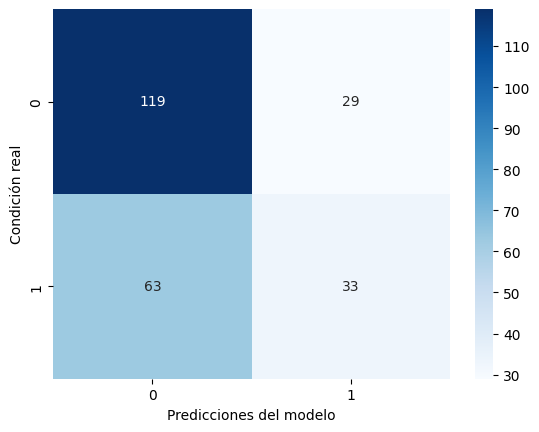

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.show()

**Regresión logística**

In [ ]:
# Define the hyperparameter grid to explore
param_grid_LR = {'C': [0.0001, 0.1, 1, 10,100],'max_iter': [1000, 2000], 'solver' : ['newton-cg', 'lbfgs', 'liblinear'], 'penalty' : [None, 'l1','l2']}

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()


# hyp tunning con gridsearch
grid_search = GridSearchCV(LR, param_grid_LR, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True)


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1216, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(mul

{'Model': LogisticRegression(C=0.1, max_iter=1000, solver='newton-cg'), 'Best Params': {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}, 'Accuracy': 0.6899669343410487, 'Classification Report': {'AUT': {'precision': 0.7152317880794702, 'recall': 0.7297297297297297, 'f1-score': 0.7224080267558528, 'support': 148}, 'CONT': {'precision': 0.5698924731182796, 'recall': 0.5520833333333334, 'f1-score': 0.5608465608465609, 'support': 96}, 'accuracy': 0.6598360655737705, 'macro avg': {'precision': 0.6425621305988749, 'recall': 0.6409065315315315, 'f1-score': 0.6416272938012069, 'support': 244}, 'weighted avg': {'precision': 0.6580491067832641, 'recall': 0.6598360655737705, 'f1-score': 0.6588428598407217, 'support': 244}}}


[[108  40]
 [ 43  53]]


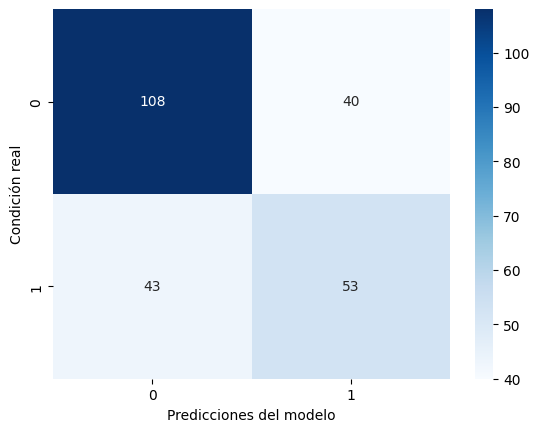

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.show()

**Árboles de Decisión**

In [ ]:
param_grid_DT = {'splitter' : ['best', 'random'], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth':  [None,1,3,5], 'min_samples_split':  [2,3,7,10], 'min_samples_leaf':  [1,2,5,8]}

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTC =  DecisionTreeClassifier()


# hyp tunning con gridsearch
grid_search = GridSearchCV(DTC, param_grid_DT, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True)


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
{'Model': DecisionTreeClassifier(max_depth=3, min_samples_leaf=8, min_samples_split=10,
                       splitter='random'), 'Best Params': {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 10, 'splitter': 'random'}, 'Accuracy': 0.6502314596126594, 'Classification Report': {'AUT': {'precision': 0.6121495327102804, 'recall': 0.8851351351351351, 'f1-score': 0.723756906077348, 'support': 148}, 'CONT': {'precision': 0.43333333333333335, 'recall': 0.13541666666666666, 'f1-score': 0.20634920634920637, 'support': 96}, 'accuracy': 0.5901639344262295, 'macro avg': {'precision': 0.5227414330218069, 'recall': 0.5102759009009009, 'f1-score': 0.4650530562132772, 'support': 244}, 'weighted avg': {'precision': 0.5417956182013176, 'recall': 0.5901639344262295, 'f1-score': 0.5201866635613579, 'support': 244}}}


[[131  17]
 [ 83  13]]


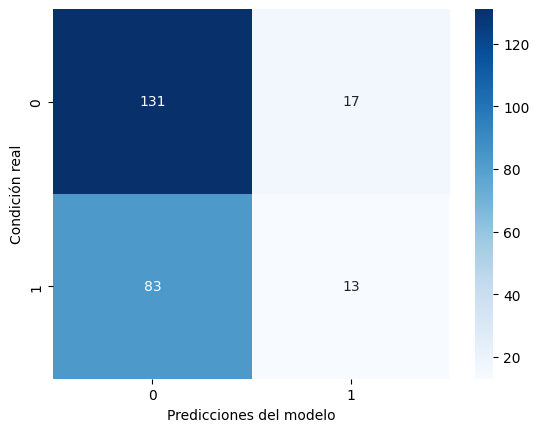

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.show()

Accuracy (Exactitud): indica la proporción de predicciones correctas sobre el total de predicciones realizadas. Aproximadamente el 68.4% de las predicciones hechas por el modelo son correctas.

F1 Score: es la media armónica de la precisión y el recall. Es útil cuando las clases están desequilibradas. Puede interpretarse como la precisión ajustada por el recall y viceversa. Un F1 score alto indica un buen equilibrio entre precisión y recall.

Precision: refiere a la proporción de predicciones positivas correctas sobre el total de predicciones positivas hechas por el modelo. El 77.5% de las veces el modelo predice correctamente AUTISTAS.

Recall (Exhaustividad o Sensibilidad):indica la proporción de observaciones positivas que fueron correctamente clasificadas. Es la verdadera positividad. El modelo identifica correctamente al 31% de los casos positivos.

<figure>
<center>
<img src='https://media.telefonicatech.com/telefonicatech/uploads/2021/1/121498_matriz.jpg' />
<figcaption>Image Caption</figcaption></center>
</figure>

### Análisis de componentes principales (PCA)

In [ ]:
# PCA es sensible a la escala
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

ss = StandardScaler()

normal_features = ss.fit_transform(features)
#X_train_std = scaler.fit_transform(X_train)
#X_test_std = scaler.fit_transform(X_test)

In [ ]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,4361,4362,4363,4364,4365,4366,4367,4368,4369,4370
0,0.884496,0.709854,0.759467,0.808396,0.748825,0.746855,0.797611,0.754630,0.699556,0.558432,...,0.759526,0.894507,0.848783,0.875080,0.853000,0.754495,0.673811,0.807199,0.812130,0.915447
1,0.913155,0.508644,0.210797,0.375724,0.136328,0.550674,0.217562,0.446146,0.257435,0.336017,...,0.491767,0.552078,0.645986,0.629501,0.814782,0.648253,0.585712,0.574145,0.465562,0.773946
2,0.693080,0.639012,0.427046,0.553249,0.370843,0.639087,0.615761,0.474038,0.523910,0.360967,...,0.510239,0.697781,0.573982,0.727019,0.648158,0.601135,0.471724,0.460433,0.525508,0.854126
3,0.674283,0.356046,0.395826,0.250278,0.315492,0.327619,0.418142,0.318003,0.344895,0.407478,...,0.608805,0.762027,0.589437,0.729525,0.827515,0.567599,0.546411,0.680090,0.719204,0.798524
4,0.631215,0.468764,0.447137,0.464821,0.383575,0.549706,0.380909,0.574176,0.417614,0.567322,...,0.546729,0.634173,0.671634,0.658479,0.599554,0.443173,0.456866,0.421308,0.572873,0.629786


In [ ]:
# esta bien normalizado? los valores me hacen ruido
print(normal_features)

[[ 1.12292510e+00  8.38364340e-01  1.24834494e+00 ...  1.91560132e+00
   1.82922839e+00  1.29690674e+00]
 [ 1.34503468e+00 -2.68203699e-01 -1.53928360e+00 ...  5.12301442e-01
  -2.92808572e-01  6.23890979e-02]
 [-3.60618691e-01  4.48766630e-01 -4.40585881e-01 ... -1.72405687e-01
   7.42414115e-02  7.61914593e-01]
 ...
 [ 1.00349483e-03  2.52111391e-01  1.05060112e+00 ... -3.90507347e-01
  -9.25888856e-02  3.64561711e-01]
 [-1.34938308e+00 -1.46436270e+00 -1.00749195e-01 ... -7.91025665e-01
  -7.49937371e-01 -9.41121318e-01]
 [ 4.24930786e-01 -5.56650280e-01  5.00432697e-01 ...  9.50793769e-01
   4.52333078e-01 -4.31626047e-01]]


In [ ]:
df_scaled = pd.DataFrame(data = normal_features)

In [ ]:
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,4361,4362,4363,4364,4365,4366,4367,4368,4369,4370
0,1.122925,0.838364,1.248345,1.386660,1.286343,0.982025,1.447683,1.256291,1.178049,0.737485,...,1.917144,2.234018,1.676896,1.494793,1.403467,1.439991,1.303360,1.915601,1.829228,1.296907
1,1.345035,-0.268204,-1.539284,-1.021335,-1.838079,-0.254219,-1.694549,-0.341922,-0.985900,-0.358903,...,0.343322,0.026837,0.345681,-0.341474,1.168263,0.800843,0.784654,0.512301,-0.292809,0.062389
2,-0.360619,0.448767,-0.440586,-0.033336,-0.641790,0.302922,0.462570,-0.197420,0.318355,-0.235915,...,0.451895,0.965987,-0.126978,0.387695,0.142814,0.517380,0.113528,-0.172406,0.074241,0.761915
3,-0.506302,-1.107426,-0.599209,-1.719486,-0.924142,-1.659817,-0.607968,-1.005814,-0.557831,-0.006637,...,1.031243,1.380093,-0.025522,0.406434,1.246626,0.315632,0.553262,1.150233,1.260245,0.276818
4,-0.840086,-0.487523,-0.338510,-0.525470,-0.576844,-0.260323,-0.809667,0.321384,-0.201909,0.781312,...,0.666372,0.555992,0.514039,-0.124801,-0.156308,-0.432914,0.026049,-0.407991,0.364258,-1.195326


PCA con 77 componentes

In [ ]:
pca = PCA(n_components= 77, random_state=42)

In [ ]:
pca_trans = pca.fit_transform(df_scaled)

In [ ]:
print('Features originales - shape:', features.shape)
print('Features PCA - shape:', pca_trans.shape)
print(pca_trans)

Features originales - shape: (973, 4371)
Features PCA - shape: (973, 77)
[[ 68.34726829 -11.79744575  -1.58290061 ...  -0.12541748   1.13780717
    0.1457752 ]
 [  4.63758931   5.63729645  -7.63262643 ...  -0.11803745   2.04616956
   -2.44281343]
 [-11.28041949  -8.89838261  -4.8645195  ...  -0.11952444  -3.54934182
    4.25015519]
 ...
 [ 11.41646434 -15.8538859    1.77629839 ...   2.37028605   2.31050673
    0.830955  ]
 [-30.19551599 -12.7338051    2.89098247 ...   0.3248906   -3.91099917
   -1.00864566]
 [-22.46403531   6.22090067 -12.2054376  ...   5.77923479   1.80847516
    4.00486491]]


In [ ]:
prop_var = pca.explained_variance_ratio_ # extrae la proporcion de la varianza explicada
print(prop_var)

[0.41130373 0.02928851 0.02679511 0.01950473 0.01878734 0.01510755
 0.01317895 0.01228843 0.01131914 0.01066543 0.0090498  0.0081717
 0.00812681 0.00731692 0.00710645 0.00695748 0.00625637 0.00589468
 0.00579131 0.00550153 0.00510483 0.00495211 0.00480598 0.00465463
 0.00441224 0.00430531 0.00404019 0.00387114 0.00371989 0.00367701
 0.00356098 0.00346488 0.00337513 0.00331641 0.00323152 0.00315557
 0.00305236 0.00296633 0.002914   0.00287465 0.0028166  0.0027724
 0.0026896  0.00265129 0.00258697 0.00255166 0.00248445 0.00245259
 0.00237938 0.00236428 0.0023041  0.00223663 0.00222465 0.00218887
 0.00216494 0.00209047 0.00206401 0.00202473 0.00197127 0.00193441
 0.00192136 0.0018843  0.00188108 0.00181012 0.0017944  0.00176572
 0.00173779 0.00171807 0.00167747 0.0016554  0.00164142 0.00162577
 0.0016098  0.00158779 0.00153023 0.00150185 0.00148722]


In [ ]:
PC_number = np.arange(pca.n_components_) + 1 # enumera los números de los componentes
print(PC_number)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77]


<function matplotlib.pyplot.show(close=None, block=None)>

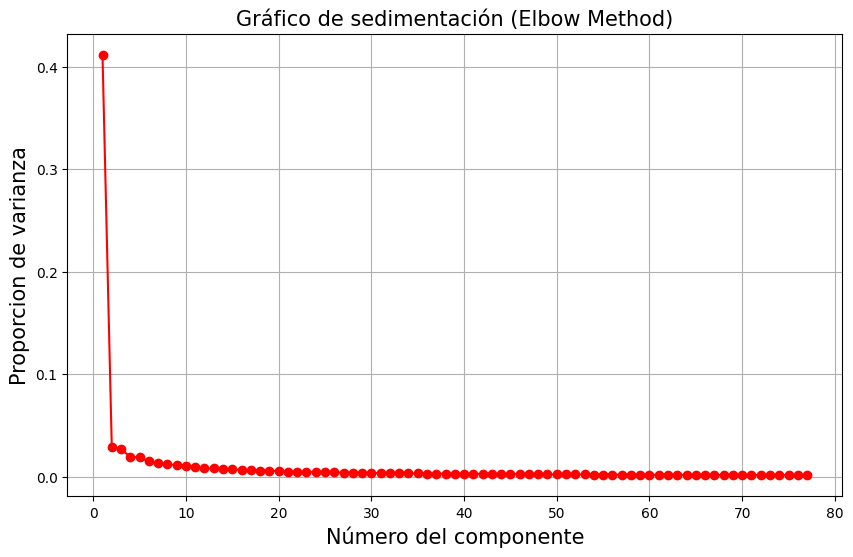

In [ ]:
# Gráfico de sedimentación

plt.figure(figsize=(10,6))
plt.plot(PC_number,
         prop_var,
         'ro-')

plt.title('Gráfico de sedimentación (Elbow Method)',
          fontsize=15)
plt.xlabel('Número del componente',
           fontsize=15)
plt.ylabel('Proporcion de varianza',
           fontsize=15)

plt.grid()
plt.show

In [ ]:
# @title
# Kaiser Rule
var = pca.explained_variance_

<function matplotlib.pyplot.show(close=None, block=None)>

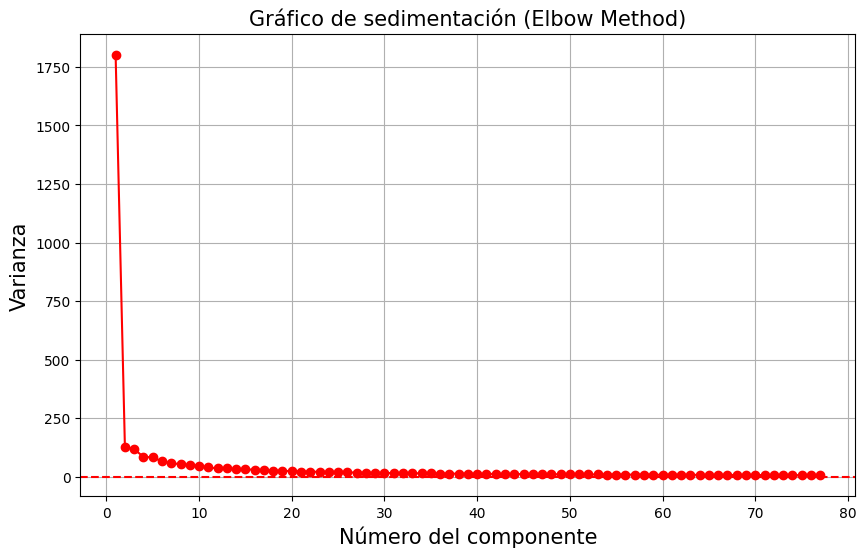

In [ ]:
# @title
# Gráfico de sedimentación x Kaiser RUle

plt.figure(figsize=(10,6))
plt.plot(PC_number,
         var,
         'ro-')

plt.title('Gráfico de sedimentación (Elbow Method)',
          fontsize=15)
plt.xlabel('Número del componente',
           fontsize=15)
plt.ylabel('Varianza',
           fontsize=15)
plt.axhline(y=1,
            color = 'r',
            linestyle = '--')


plt.grid()
plt.show

PCA con 2 componentes

In [ ]:
# corro PCA con 2 componentes

pca = PCA(n_components = 2)
PC = pca.fit_transform(df_scaled)
print(PC)
print(PC.shape)

# Los componentes principales PC son combinaciones lineales de las variables originales

[[ 68.34726829 -11.79736848]
 [  4.63758931   5.6368971 ]
 [-11.28041949  -8.8983943 ]
 ...
 [ 11.41646434 -15.85391064]
 [-30.19551599 -12.73365576]
 [-22.46403531   6.22055696]]
(973, 2)


In [ ]:
# biplot data
# extraigo ambos componentes
PC1= PC[:,0]
PC2 = PC[:,1]

In [ ]:
loadings = pca.components_ # explica la asociacion entre los componentes y las variables originales

# loadings son los coeficientes que indican la relacion entre las variables originales y los componentes principales
# multiplican cada variable original en la combinacion lineal que forma cada componente principal
print(loadings)
print(loadings.shape)

# hay dos rows representando cada componente, y las 4371 variables originales

[[0.01384749 0.01578702 0.01684336 ... 0.01042089 0.00995147 0.0120216 ]
 [0.01551885 0.0220547  0.02039035 ... 0.01468796 0.02181827 0.01102528]]
(2, 4371)


In [ ]:
scalePC1 = 1.0/(PC1.max()-PC1.min())
print(scalePC1)

scalePC2 = 1.0/(PC2.max()-PC2.min())
print(scalePC2)


0.004269280002383269
0.014086164503730646


In [ ]:
cond = df['condicion']

In [ ]:
print(loadings)

[[0.01384749 0.01578702 0.01684336 ... 0.01042089 0.00995147 0.0120216 ]
 [0.01551815 0.02205481 0.02038979 ... 0.01468787 0.02181873 0.01102364]]


In [ ]:
np.save('/content/drive/MyDrive/Favaloro/Tesis/PC.npy', PC)
np.save('/content/drive/MyDrive/Favaloro/Tesis/loadings.npy', loadings)

In [ ]:
PC = np.load('/content/drive/MyDrive/Favaloro/Tesis/PC.npy')
loadings = np.load('/content/drive/MyDrive/Favaloro/Tesis/loadings.npy')

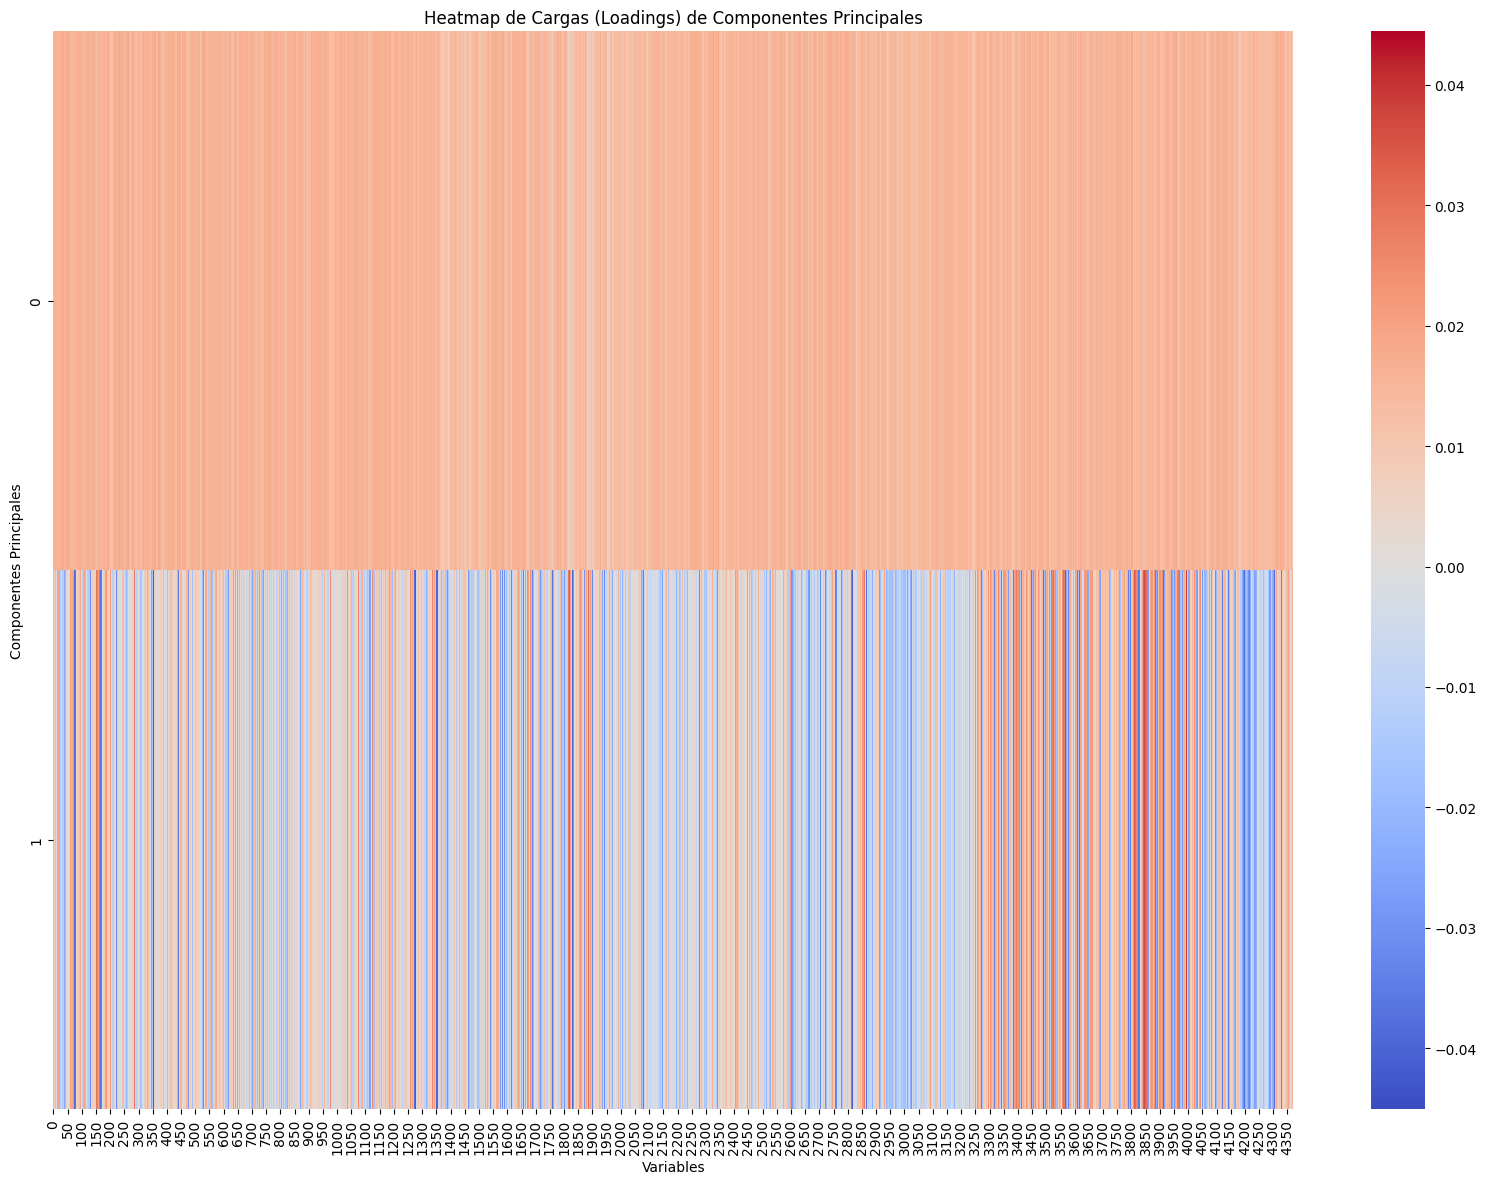

In [ ]:
# @title
# heatmat de las loadings (cargas)
plt.figure(figsize=(20, 14))
sns.heatmap(loadings,
            #annot=True,
            cmap='coolwarm')
plt.title('Heatmap de Cargas (Loadings) de Componentes Principales')
plt.xlabel('Variables')
plt.ylabel('Componentes Principales')
plt.show()


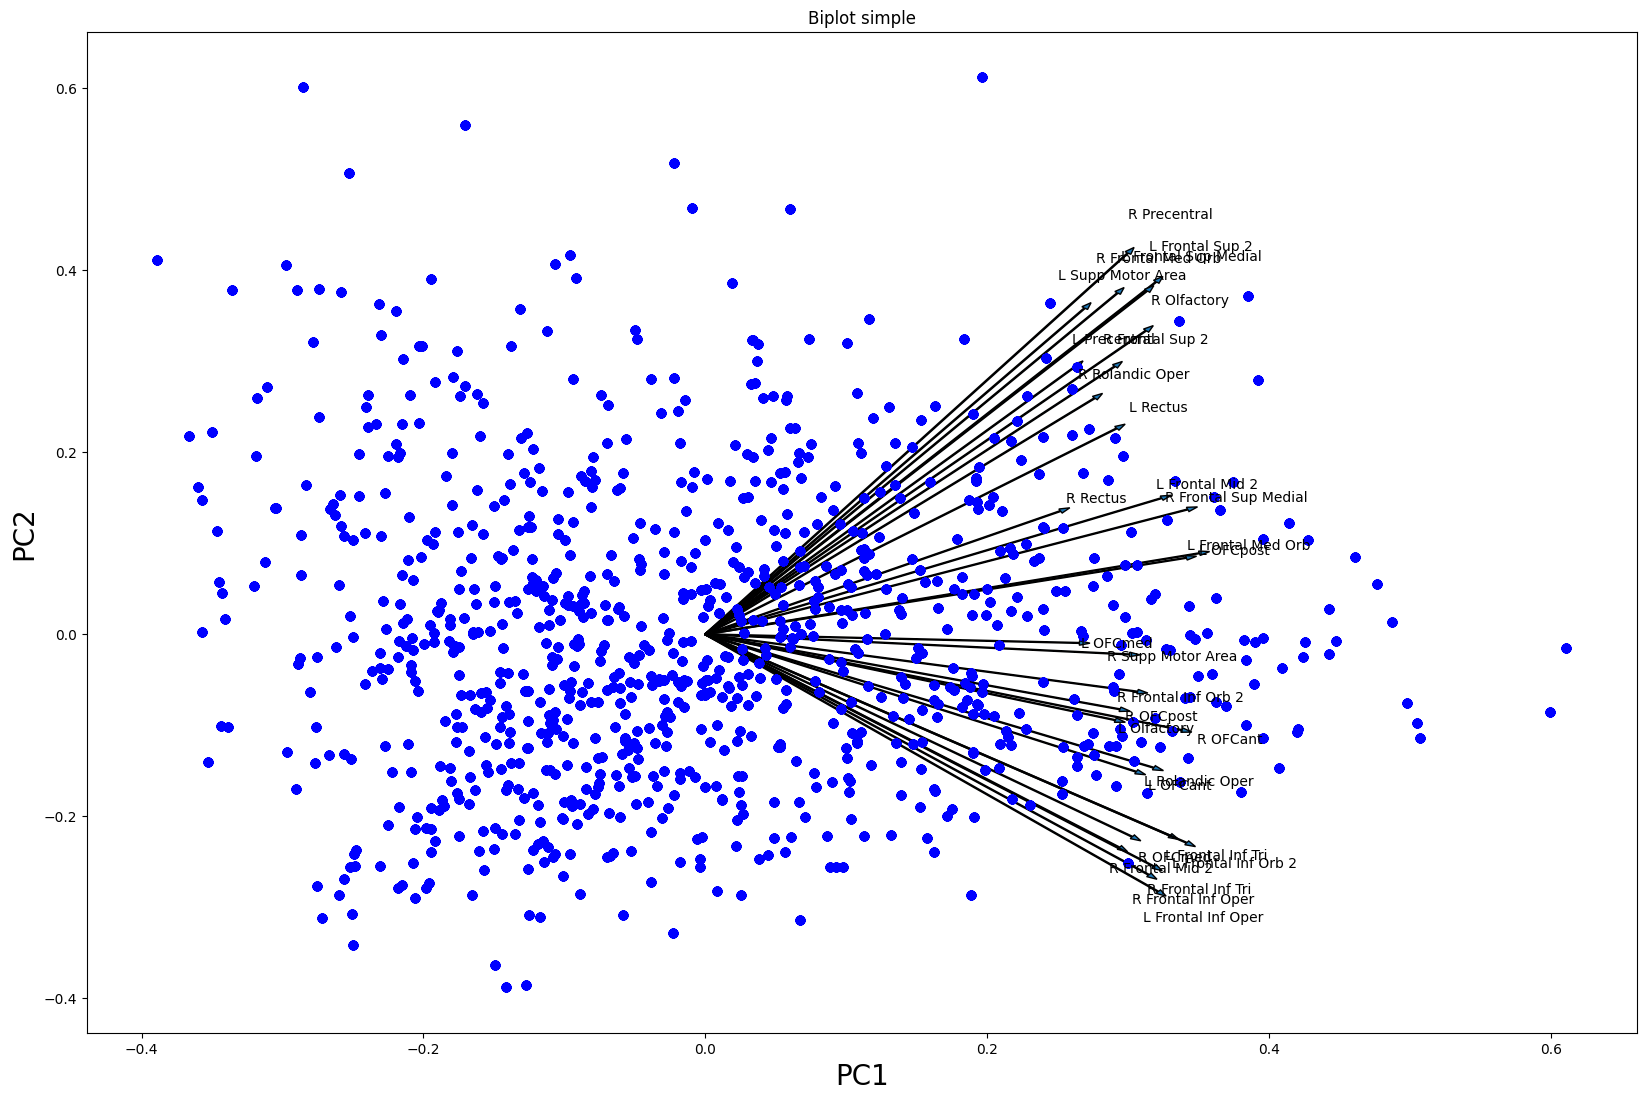

In [ ]:
# @title
# https://statisticsglobe.com/biplot-pca-explained

# simple biplot

fig,ax = plt.subplots(figsize=(20,13))

arrow_scale = 19


for i, roi in enumerate(rois[:30]): # itero por las distintas variables (rois)
  ax.arrow(0,   #plot arrows
           0,
           loadings[0,i] * arrow_scale,
           loadings[1,i] * arrow_scale,
           #width = 0.0001,
           head_width = 0.005,
           #head_length = 0.5,
           #length_includes_head = 7,
           #color='grey',
           #linewidth = 1.0,
          # head_starts_at_zero = True
           #shape= 'left'
           )
  ax.text(loadings[0, i] * arrow_scale * 1.1,
          loadings[1, i] * arrow_scale * 1.1,
          roi,
          fontsize=10, ha='center', va='center')

  ax.scatter(PC1 * scalePC1,
             PC2 * scalePC2,
             color='Blue')
  ax.set_xlabel('PC1',
                fontsize = 20)
  ax.set_ylabel('PC2',
                fontsize = 20)
  ax.set_title('Biplot simple')

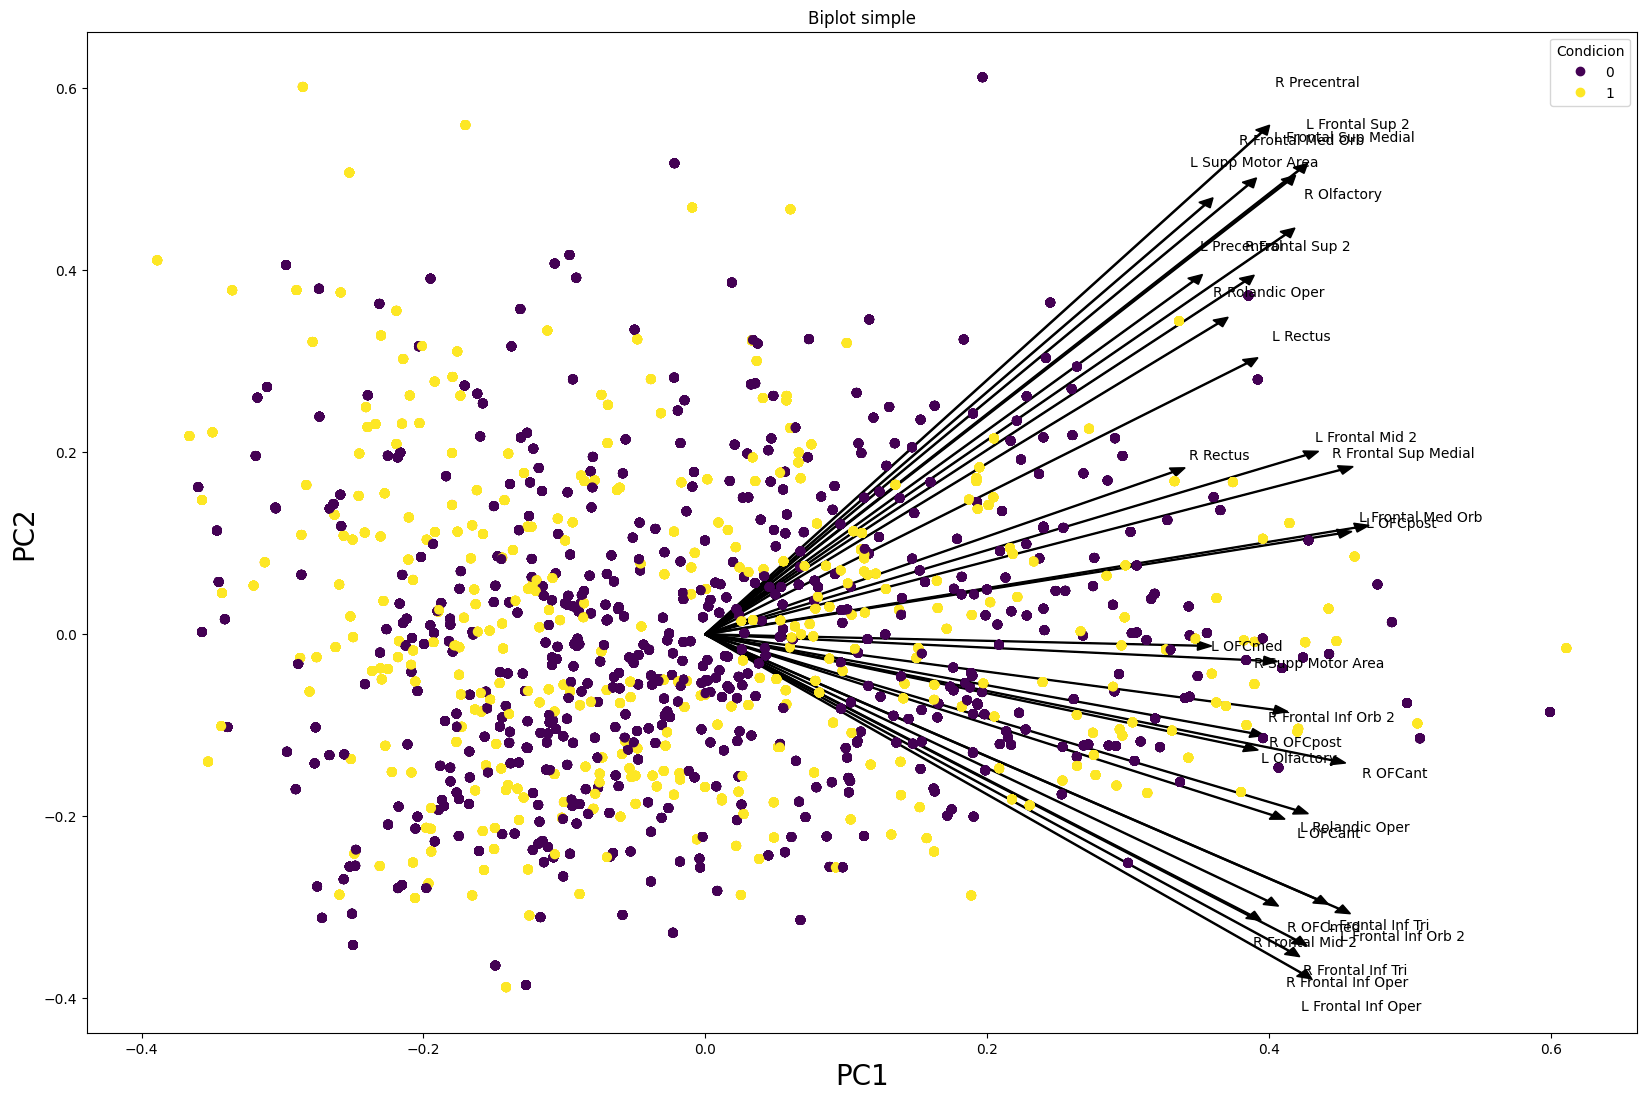

In [ ]:
# @title
# Biplot x condicion

fig,ax = plt.subplots(figsize=(20,13))

arrow_scale = 25


for i, roi in enumerate(rois[:30]): # itero por las distintas variables (rois)
  ax.arrow(0,   #plot arrows
           0,
           loadings[0,i] * arrow_scale,
           loadings[1,i] * arrow_scale,
           #width = 0.0001,
           head_width = 0.01,
           head_length = 0.01,
           #length_includes_head = 7,
           color='black',
           #linewidth = 1.0,
          # head_starts_at_zero = True
           #shape= 'left'
           )
  ax.text(loadings[0, i] * arrow_scale * 1.1,
          loadings[1, i] * arrow_scale * 1.1,
          roi,
          fontsize=10, ha='center', va='center')

  scatter = ax.scatter(PC1 * scalePC1, PC2 * scalePC2, c = cond, cmap='viridis')
  ax.set_xlabel('PC1',
                fontsize = 20)
  ax.set_ylabel('PC2',
                fontsize = 20)
  ax.set_title('Biplot simple')
  ax.legend(*scatter.legend_elements(),
            loc = "upper right",
            title = "Condicion")

In [ ]:

df_pc = pd.DataFrame(data = PC,
                      columns = ['PC1', 'PC2' ])
df_pc['group'] = df['condicion']
df_pc.head()

,PC1,PC2,group
0,68.347268,-11.797631,1
1,4.637589,5.637387,0
2,-11.280419,-8.898855,1
3,0.149551,-3.570022,0
4,-9.513558,-13.106227,0


In [ ]:
np.save('/content/drive/MyDrive/Favaloro/Tesis/df_pc.csv', df_pc)

In [ ]:
PC = np.load('/content/drive/MyDrive/Favaloro/Tesis/PC.npy')

In [ ]:
# Controles = cero: 0
# Autistas = uno: 1

cont_PC1 = df_pc.loc[df_pc['group']== 0, 'PC1']
cont_PC2 = df_pc.loc[df_pc['group']== 0, 'PC2']

aut_PC1 = df_pc.loc[df_pc['group'] == 1, 'PC1']
aut_PC2 = df_pc.loc[df_pc['group'] == 1, 'PC2']

In [ ]:
# escalar la data nueva

scale_PC1_cont = 1.0/(cont_PC1.max() - cont_PC1.min())
scale_PC2_cont = 1.0/(cont_PC2.max() - cont_PC2.min())

scale_PC1_aut = 1.0/(aut_PC1.max() - aut_PC1.min())
scale_PC2_aut = 1.0/(aut_PC2.max() - aut_PC2.min())

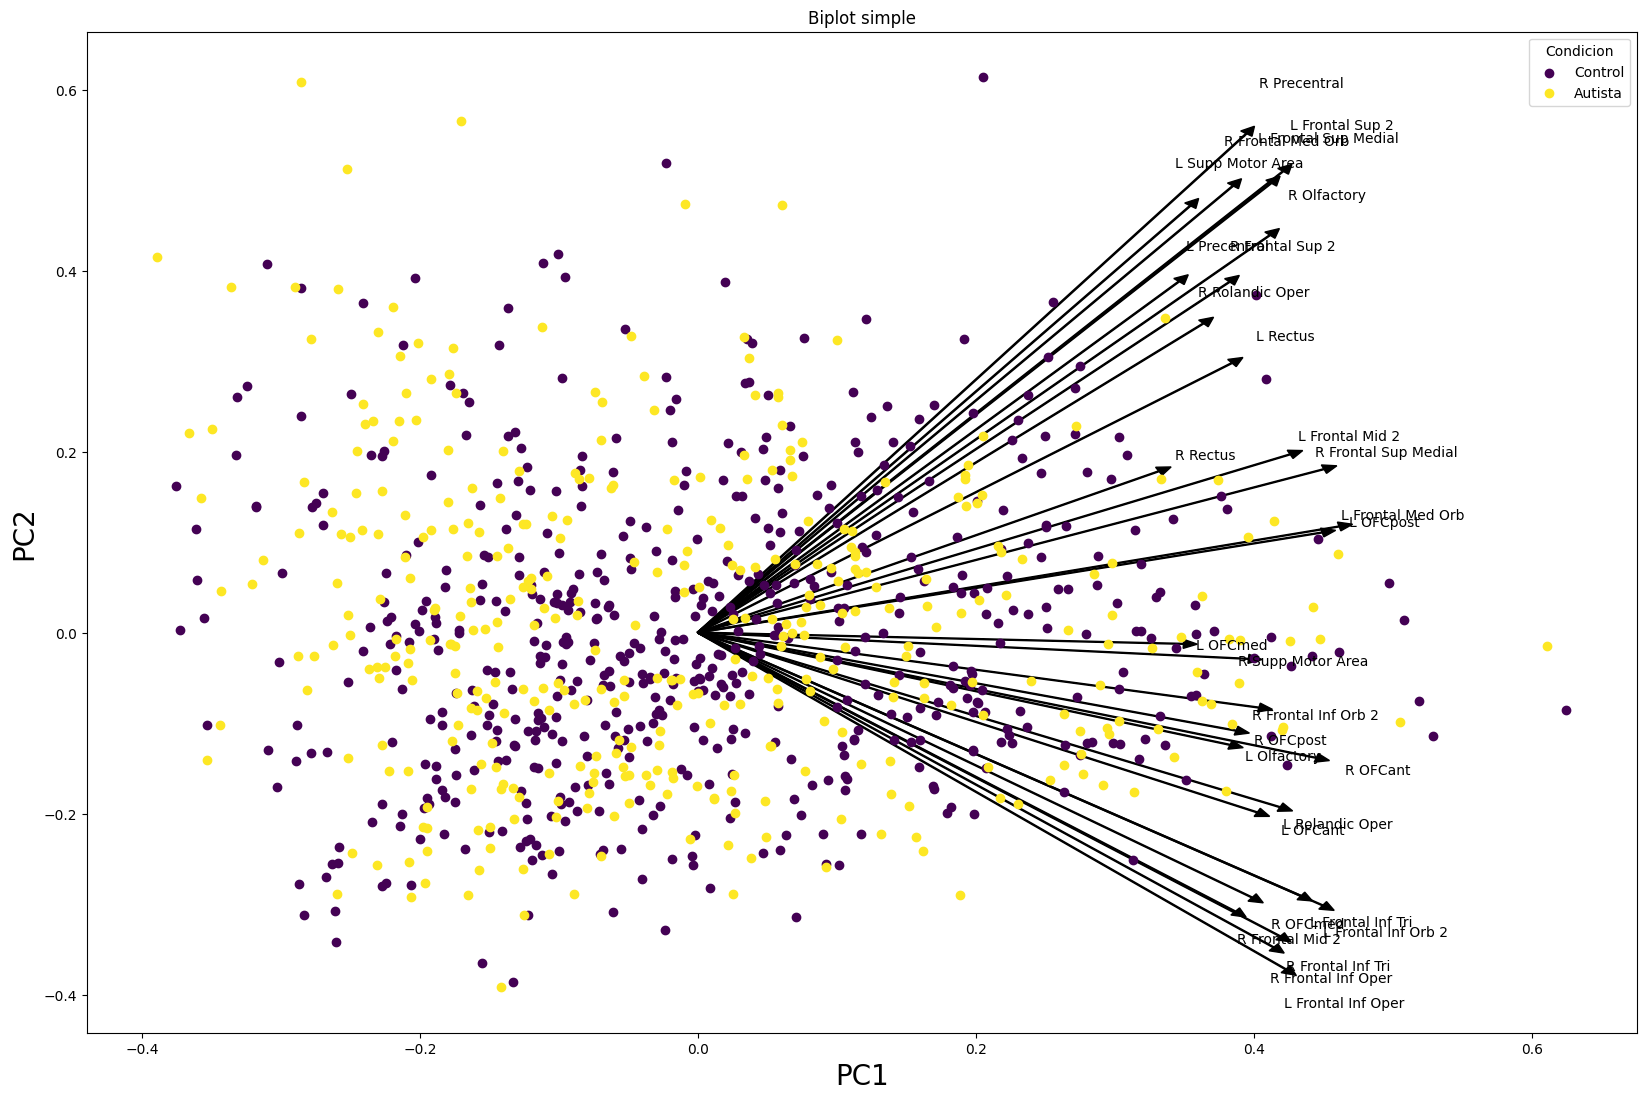

In [ ]:
# Biplot x condicion

fig,ax = plt.subplots(figsize=(20,13))

arrow_scale = 25


for i, roi in enumerate(rois[:30]): # itero por las distintas variables (rois)
  ax.arrow(0,   #plot arrows
           0,
           loadings[0,i] * arrow_scale,
           loadings[1,i] * arrow_scale,
           #width = 0.0001,
           head_width = 0.01,
           head_length = 0.01,
           #length_includes_head = 7,
           color='black',
           #linewidth = 1.0,
          # head_starts_at_zero = True
           #shape= 'left'
           )
  ax.text(loadings[0, i] * arrow_scale * 1.1,
          loadings[1, i] * arrow_scale * 1.1,
          roi,
          fontsize=10, ha='center', va='center')

scatter = ax.scatter(cont_PC1 * scale_PC1_cont,
                       cont_PC2 * scale_PC2_cont,
                       c="#440154",
                       label = 'Control')

scatter = ax.scatter(aut_PC1 * scale_PC1_aut,
                       aut_PC2 * scale_PC2_aut,
                       c="#FDE724",
                       label = 'Autista')


ax.set_xlabel('PC1',
                fontsize = 20)
ax.set_ylabel('PC2',
                fontsize = 20)
ax.set_title('Biplot simple')

leyenda = ax.legend(loc = "upper right",title = "Condicion")

# Clasificadores con componentes principales

In [ ]:
df_pc = pd.read_csv('/content/drive/MyDrive/Favaloro/Tesis/df_pc.csv')

In [ ]:
df_pc.head()

,PC1,PC2,group
0,68.347268,-11.797539,1
1,4.637589,5.636807,0
2,-11.280419,-8.898439,1
3,0.149551,-3.570228,0
4,-9.513558,-13.106316,0


In [ ]:
from sklearn.model_selection import train_test_split

X = df_pc.drop(['group'], axis=1)
y = df_pc['group'].values
y.shape

(973,)

In [ ]:
# División de los datos en conjuntos de entrenamiento y prueba con PC

X_train_PC, X_test_PC, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.25)
# Stratify balancea la cantidad de sujetos de cada condicion en la división de os datos

print(f'X_train: {X_train_PC.shape}')
print(f'X_test: {X_test_PC.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (729, 2)
X_test: (244, 2)
y_train: (729,)
y_test: (244,)


**Máquinas de Vectores de Soporte con Componentes Principales**

In [ ]:
# Define the hyperparameter grid to explore
#param_grid = {'C': [0.0001, 0.1, 1, 10,100], 'degree': [1,2,3,5,8,10], 'gamma': ['auto','scale'],'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
param_grid = {'C': [0.1, 1], 'degree': [3,5], 'gamma': ['scale'],'kernel': ['poly']}

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
svm = SVC()


# hyp tunning con gridsearch
grid_search = GridSearchCV(svm, param_grid, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train_PC, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_PC)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True)


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'Model': SVC(C=1, degree=5, kernel='poly'), 'Best Params': {'C': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}, 'Accuracy': 0.6172791686348607, 'Classification Report': {'AUT': {'precision': 0.6049382716049383, 'recall': 0.9932432432432432, 'f1-score': 0.751918158567775, 'support': 148}, 'CONT': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 96}, 'accuracy': 0.6024590163934426, 'macro avg': {'precision': 0.30246913580246915, 'recall': 0.4966216216216216, 'f1-score': 0.3759590792838875, 'support': 244}, 'weighted avg': {'precision': 0.366929771301356, 'recall': 0.6024590163934426, 'f1-score': 0.45608150601651926, 'support': 244}}}


[[147   1]
 [ 96   0]]


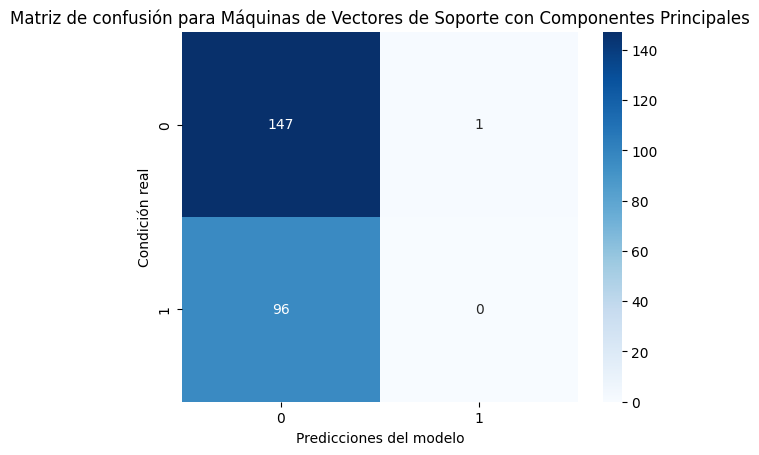

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.title('Matriz de confusión para Máquinas de Vectores de Soporte con Componentes Principales')
plt.show()

**Bósques Aleatorios con Componentes Principales**

In [ ]:
param_grid_RF = {'n_estimators': [1000], 'max_depth': [5,20,None] }

In [ ]:
y_train = y_train.astype(float)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

RF = RandomForestClassifier()

# hyp tunning con gridsearch
grid_search = GridSearchCV(RF, param_grid_RF, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train_PC, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_PC)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True) # la función usa las etiquetas de clase reales (0 y 1) para calcular las métricas, y el parámetro target_names solo se usa con fines de visualización.


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
#resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
#resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'Model': RandomForestClassifier(max_depth=5, n_estimators=1000), 'Best Params': {'max_depth': 5, 'n_estimators': 1000}, 'Accuracy': 0.6049220595181861, 'Classification Report': {'AUT': {'precision': 0.6066350710900474, 'recall': 0.8648648648648649, 'f1-score': 0.7130919220055711, 'support': 148}, 'CONT': {'precision': 0.3939393939393939, 'recall': 0.13541666666666666, 'f1-score': 0.20155038759689922, 'support': 96}, 'accuracy': 0.5778688524590164, 'macro avg': {'precision': 0.5002872325147207, 'recall': 0.5001407657657658, 'f1-score': 0.4573211548012352, 'support': 244}, 'weighted avg': {'precision': 0.5229515259815936, 'recall': 0.5778688524590164, 'f1-score': 0.5118296789595362, 'support': 244}}}


[[128  20]
 [ 83  13]]


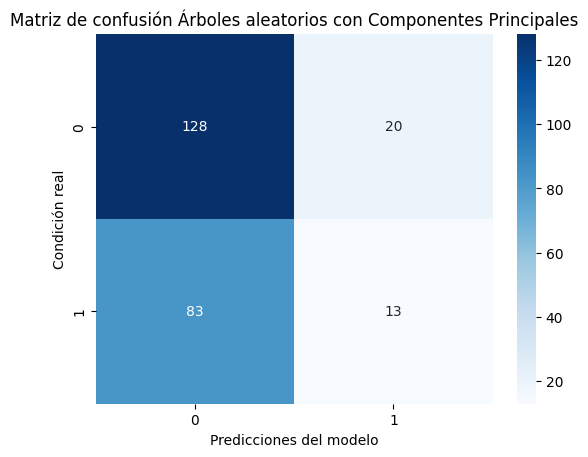

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.title('Matriz de confusión Árboles aleatorios con Componentes Principales')
plt.show()

**Regresión logística con Componentes Principales**

In [ ]:
# Define the hyperparameter grid to explore
param_grid_LR = {'C': [0.0001, 0.1, 1, 10,100],'max_iter': [1000, 2000], 'solver' : ['newton-cg', 'lbfgs', 'liblinear'], 'penalty' : [None, 'l1','l2']}

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()


# hyp tunning con gridsearch
grid_search = GridSearchCV(LR, param_grid_LR, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train_PC, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_PC)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True)


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'Model': LogisticRegression(C=0.0001, max_iter=1000, solver='newton-cg'), 'Best Params': {'C': 0.0001, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}, 'Accuracy': 0.6117997165800662, 'Classification Report': {'AUT': {'precision': 0.6090534979423868, 'recall': 1.0, 'f1-score': 0.7570332480818415, 'support': 148}, 'CONT': {'precision': 1.0, 'recall': 0.010416666666666666, 'f1-score': 0.020618556701030924, 'support': 96}, 'accuracy': 0.610655737704918, 'macro avg': {'precision': 0.8045267489711934, 'recall': 0.5052083333333334, 'f1-score': 0.3888259023914362, 'support': 244}, 'weighted avg': {'precision': 0.7628685151453822, 'recall': 0.610655737704918, 'f1-score': 0.467296320325457, 'support': 244}}}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1216, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(mul

[[148   0]
 [ 95   1]]


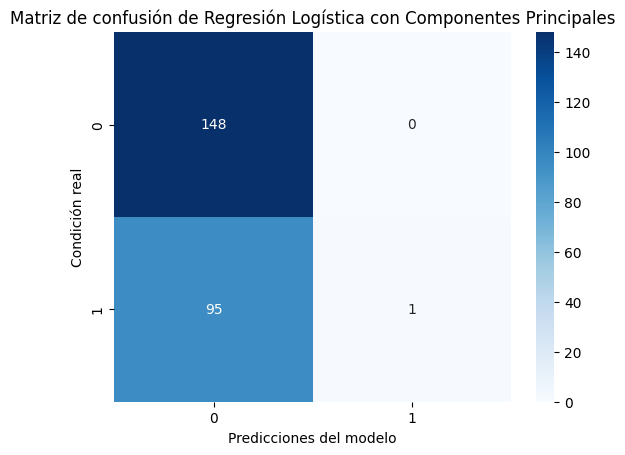

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.title('Matriz de confusión de Regresión Logística con Componentes Principales')
plt.show()

**Árboles de Decisión con Componentes Principales**

In [ ]:
param_grid_DT = {'splitter' : ['best', 'random'], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth':  [None,1,3,5], 'min_samples_split':  [2,3,7,10], 'min_samples_leaf':  [1,2,5,8]}

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTC =  DecisionTreeClassifier()


# hyp tunning con gridsearch
grid_search = GridSearchCV(DTC, param_grid_DT, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train_PC, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_PC)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True)


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
{'Model': DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=8,
                       splitter='random'), 'Best Params': {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 2, 'splitter': 'random'}, 'Accuracy': 0.6336986301369862, 'Classification Report': {'AUT': {'precision': 0.6136363636363636, 'recall': 0.9121621621621622, 'f1-score': 0.7336956521739131, 'support': 148}, 'CONT': {'precision': 0.4583333333333333, 'recall': 0.11458333333333333, 'f1-score': 0.18333333333333332, 'support': 96}, 'accuracy': 0.5983606557377049, 'macro avg': {'precision': 0.5359848484848485, 'recall': 0.5133727477477478, 'f1-score': 0.4585144927536232, 'support': 244}, 'weighted avg': {'precision': 0.5525335320417287, 'recall': 0.5983606557377049, 'f1-score': 0.5171596578759801, 'support': 244}}}


[[135  13]
 [ 85  11]]


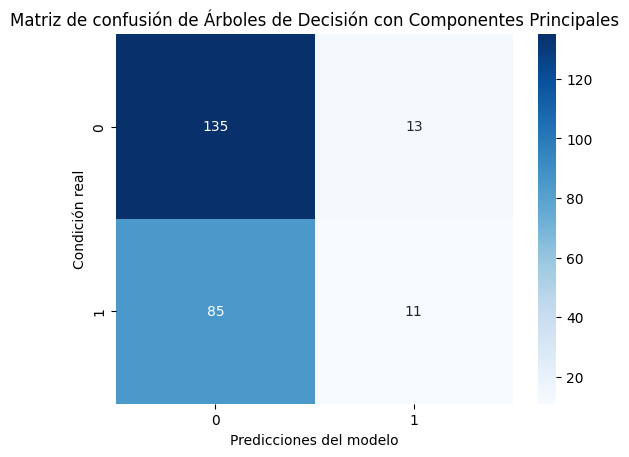

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.title('Matriz de confusión de Árboles de Decisión con Componentes Principales')
plt.show()

# Clasificadores con componentes principales

In [ ]:
df_pc = pd.read_csv('/content/drive/MyDrive/Favaloro/Tesis/df_pc.csv')

In [ ]:
df_pc.head()

,PC1,PC2,group
0,68.347268,-11.797539,1
1,4.637589,5.636807,0
2,-11.280419,-8.898439,1
3,0.149551,-3.570228,0
4,-9.513558,-13.106316,0


In [ ]:
from sklearn.model_selection import train_test_split

X = df_pc.drop(['group'], axis=1)
y = df_pc['group'].values
y.shape

(973,)

In [ ]:
# División de los datos en conjuntos de entrenamiento y prueba con PC

X_train_PC, X_test_PC, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.25)
# Stratify balancea la cantidad de sujetos de cada condicion en la división de os datos

print(f'X_train: {X_train_PC.shape}')
print(f'X_test: {X_test_PC.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (729, 2)
X_test: (244, 2)
y_train: (729,)
y_test: (244,)


**Máquinas de Vectores de Soporte con Componentes Principales**

In [ ]:
# Define the hyperparameter grid to explore
#param_grid = {'C': [0.0001, 0.1, 1, 10,100], 'degree': [1,2,3,5,8,10], 'gamma': ['auto','scale'],'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
param_grid = {'C': [0.1, 1], 'degree': [3,5], 'gamma': ['scale'],'kernel': ['poly']}

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
svm = SVC()


# hyp tunning con gridsearch
grid_search = GridSearchCV(svm, param_grid, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train_PC, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_PC)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True)


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'Model': SVC(C=1, degree=5, kernel='poly'), 'Best Params': {'C': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}, 'Accuracy': 0.6172791686348607, 'Classification Report': {'AUT': {'precision': 0.6049382716049383, 'recall': 0.9932432432432432, 'f1-score': 0.751918158567775, 'support': 148}, 'CONT': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 96}, 'accuracy': 0.6024590163934426, 'macro avg': {'precision': 0.30246913580246915, 'recall': 0.4966216216216216, 'f1-score': 0.3759590792838875, 'support': 244}, 'weighted avg': {'precision': 0.366929771301356, 'recall': 0.6024590163934426, 'f1-score': 0.45608150601651926, 'support': 244}}}


[[147   1]
 [ 96   0]]


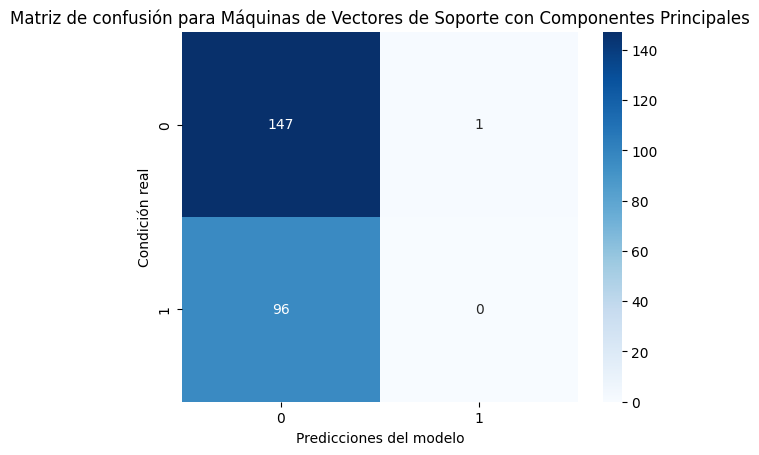

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.title('Matriz de confusión para Máquinas de Vectores de Soporte con Componentes Principales')
plt.show()

**Bósques Aleatorios con Componentes Principales**

In [ ]:
param_grid_RF = {'n_estimators': [1000], 'max_depth': [5,20,None] }

In [ ]:
y_train = y_train.astype(float)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

RF = RandomForestClassifier()

# hyp tunning con gridsearch
grid_search = GridSearchCV(RF, param_grid_RF, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train_PC, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_PC)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True) # la función usa las etiquetas de clase reales (0 y 1) para calcular las métricas, y el parámetro target_names solo se usa con fines de visualización.


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
#resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
#resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'Model': RandomForestClassifier(max_depth=5, n_estimators=1000), 'Best Params': {'max_depth': 5, 'n_estimators': 1000}, 'Accuracy': 0.6049220595181861, 'Classification Report': {'AUT': {'precision': 0.6066350710900474, 'recall': 0.8648648648648649, 'f1-score': 0.7130919220055711, 'support': 148}, 'CONT': {'precision': 0.3939393939393939, 'recall': 0.13541666666666666, 'f1-score': 0.20155038759689922, 'support': 96}, 'accuracy': 0.5778688524590164, 'macro avg': {'precision': 0.5002872325147207, 'recall': 0.5001407657657658, 'f1-score': 0.4573211548012352, 'support': 244}, 'weighted avg': {'precision': 0.5229515259815936, 'recall': 0.5778688524590164, 'f1-score': 0.5118296789595362, 'support': 244}}}


[[128  20]
 [ 83  13]]


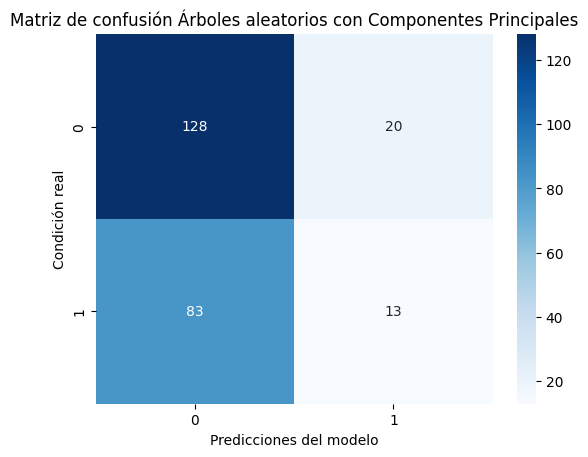

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.title('Matriz de confusión Árboles aleatorios con Componentes Principales')
plt.show()

**Regresión logística con Componentes Principales**

In [ ]:
# Define the hyperparameter grid to explore
param_grid_LR = {'C': [0.0001, 0.1, 1, 10,100],'max_iter': [1000, 2000], 'solver' : ['newton-cg', 'lbfgs', 'liblinear'], 'penalty' : [None, 'l1','l2']}

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()


# hyp tunning con gridsearch
grid_search = GridSearchCV(LR, param_grid_LR, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train_PC, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_PC)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True)


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'Model': LogisticRegression(C=0.0001, max_iter=1000, solver='newton-cg'), 'Best Params': {'C': 0.0001, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}, 'Accuracy': 0.6117997165800662, 'Classification Report': {'AUT': {'precision': 0.6090534979423868, 'recall': 1.0, 'f1-score': 0.7570332480818415, 'support': 148}, 'CONT': {'precision': 1.0, 'recall': 0.010416666666666666, 'f1-score': 0.020618556701030924, 'support': 96}, 'accuracy': 0.610655737704918, 'macro avg': {'precision': 0.8045267489711934, 'recall': 0.5052083333333334, 'f1-score': 0.3888259023914362, 'support': 244}, 'weighted avg': {'precision': 0.7628685151453822, 'recall': 0.610655737704918, 'f1-score': 0.467296320325457, 'support': 244}}}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1216, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(mul

[[148   0]
 [ 95   1]]


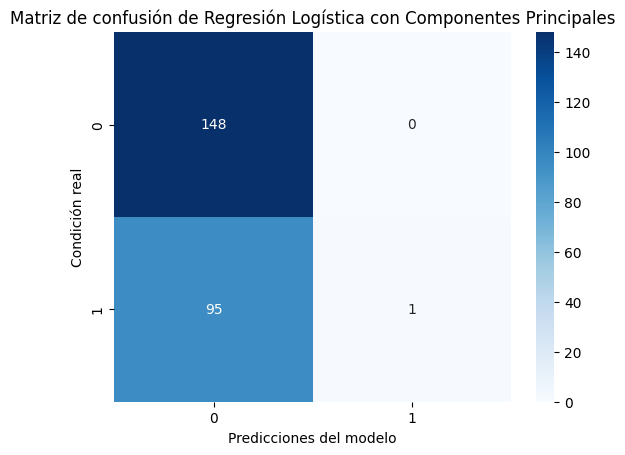

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.title('Matriz de confusión de Regresión Logística con Componentes Principales')
plt.show()

**Árboles de Decisión con Componentes Principales**

In [ ]:
param_grid_DT = {'splitter' : ['best', 'random'], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth':  [None,1,3,5], 'min_samples_split':  [2,3,7,10], 'min_samples_leaf':  [1,2,5,8]}

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTC =  DecisionTreeClassifier()


# hyp tunning con gridsearch
grid_search = GridSearchCV(DTC, param_grid_DT, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train_PC, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_PC)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True)


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
{'Model': DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=8,
                       splitter='random'), 'Best Params': {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 2, 'splitter': 'random'}, 'Accuracy': 0.6336986301369862, 'Classification Report': {'AUT': {'precision': 0.6136363636363636, 'recall': 0.9121621621621622, 'f1-score': 0.7336956521739131, 'support': 148}, 'CONT': {'precision': 0.4583333333333333, 'recall': 0.11458333333333333, 'f1-score': 0.18333333333333332, 'support': 96}, 'accuracy': 0.5983606557377049, 'macro avg': {'precision': 0.5359848484848485, 'recall': 0.5133727477477478, 'f1-score': 0.4585144927536232, 'support': 244}, 'weighted avg': {'precision': 0.5525335320417287, 'recall': 0.5983606557377049, 'f1-score': 0.5171596578759801, 'support': 244}}}


[[135  13]
 [ 85  11]]


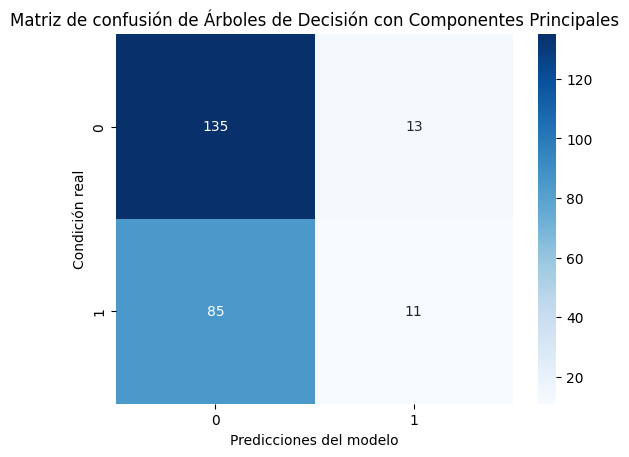

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.title('Matriz de confusión de Árboles de Decisión con Componentes Principales')
plt.show()

# Modelos con Resampling + AUC

In [ ]:

metrics_df = pd.DataFrame(columns=["Model", "Best Params", "Accuracy", "Precision", "Recall", "F1 Score", "AUC"])



In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_res, y_train_res)
baseline_accuracy = dummy_clf.score(X_test, y_test)
print(f"Baseline accuracy: {baseline_accuracy}")


Baseline accuracy: 0.6065573770491803


In [ ]:
# Define the hyperparameter grid to explore
param_grid = {'C': [0.0001, 0.1, 1, 10,100], 'degree': [1,2,3,5,8,10], 'gamma': ['auto','scale'],'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
svm = SVC()


# hyp tunning con gridsearch
grid_search = GridSearchCV(svm, param_grid, scoring='accuracy' , n_jobs=-1, verbose=1, probability=True)
grid_search.fit(X_train_res, y_train_res)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True)


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}
metrics_df = metrics_df.append(result, ignore_index=True)

# Print the classification report
print(result)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
{'Model': SVC(C=1, degree=5, kernel='poly'), 'Best Params': {'C': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}, 'Accuracy': 0.6626392067124334, 'Classification Report': {'AUT': {'precision': 0.7563025210084033, 'recall': 0.6081081081081081, 'f1-score': 0.6741573033707865, 'support': 148}, 'CONT': {'precision': 0.536, 'recall': 0.6979166666666666, 'f1-score': 0.6063348416289593, 'support': 96}, 'accuracy': 0.6434426229508197, 'macro avg': {'precision': 0.6461512605042017, 'recall': 0.6530123873873874, 'f1-score': 0.6402460724998729, 'support': 244}, 'weighted avg': {'precision': 0.669626119300179, 'recall': 0.6434426229508197, 'f1-score': 0.6474730561281004, 'support': 244}}}


[[90 58]
 [29 67]]


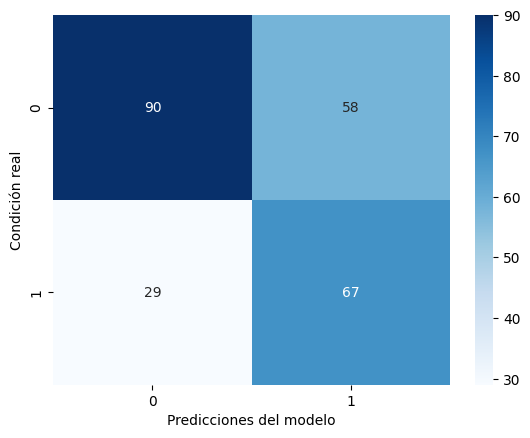

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.show()

In [ ]:

print(f"Difference from baseline: {0.6626392067124334 - baseline_accuracy}")


Difference from baseline: 0.056081829663253036


NameError: name 'y_score' is not defined

In [ ]:
from sklearn.metrics import roc_curve, auc, roc_auc_score



y_score = svm.predict_proba(X_test)[:, 1]

# Calcular los valores de tasa de verdaderos positivos (TPR), tasa de falsos positivos (FPR) y los umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_score)



# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)



# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


AttributeError: predict_proba is not available when  probability=False

In [ ]:
def extract_metrics(report):
    precision = (report['AUT']['precision'] + report['CONT']['precision']) / 2
    recall = (report['AUT']['recall'] + report['CONT']['recall']) / 2
    f1_score = (report['AUT']['f1-score'] + report['CONT']['f1-score']) / 2
    return precision, recall, f1_score


In [ ]:
precision, recall, f1_score = extract_metrics(result['Classification Report'])
auc_score = roc_auc_score(y_test, y_score)

new_row = {
    "Model": "SVM",
    "Best Params": result['Best Params'],
    "Accuracy": result['Accuracy'],
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1_score,
    "AUC": auc_score
}

metrics_df = metrics_df.append(new_row, ignore_index=True)


**Bósques Aleatorios**

In [ ]:
param_grid_RF = {'n_estimators': [1000], 'max_depth': [5,20,None] }

In [ ]:
y_train = y_train.astype(float)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

RF = RandomForestClassifier()

# hyp tunning con gridsearch
grid_search = GridSearchCV(RF, param_grid_RF, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train_res, y_train_res)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True) # la función usa las etiquetas de clase reales (0 y 1) para calcular las métricas, y el parámetro target_names solo se usa con fines de visualización.


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}



# Print the classification report
print(result)

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc

y_score = RF.predict_proba(X_test)[:, 1]

# Calcular los valores de tasa de verdaderos positivos (TPR), tasa de falsos positivos (FPR) y los umbrales
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calcular el área bajo la curva ROC (AUC)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

**Regresión logística**

In [ ]:
# Define the hyperparameter grid to explore
param_grid_LR = {'C': [0.0001, 0.1, 1, 10,100],'max_iter': [1000, 2000], 'solver' : ['newton-cg', 'lbfgs', 'liblinear'], 'penalty' : [None, 'l1','l2']}

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()


# hyp tunning con gridsearch
grid_search = GridSearchCV(LR, param_grid_LR, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True)


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1216, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(mul

{'Model': LogisticRegression(C=0.1, max_iter=1000, solver='newton-cg'), 'Best Params': {'C': 0.1, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}, 'Accuracy': 0.6899669343410487, 'Classification Report': {'AUT': {'precision': 0.7152317880794702, 'recall': 0.7297297297297297, 'f1-score': 0.7224080267558528, 'support': 148}, 'CONT': {'precision': 0.5698924731182796, 'recall': 0.5520833333333334, 'f1-score': 0.5608465608465609, 'support': 96}, 'accuracy': 0.6598360655737705, 'macro avg': {'precision': 0.6425621305988749, 'recall': 0.6409065315315315, 'f1-score': 0.6416272938012069, 'support': 244}, 'weighted avg': {'precision': 0.6580491067832641, 'recall': 0.6598360655737705, 'f1-score': 0.6588428598407217, 'support': 244}}}


[[108  40]
 [ 43  53]]


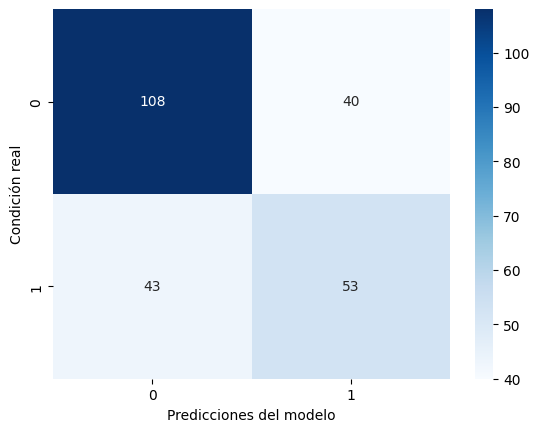

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.show()

**Árboles de Decisión**

In [ ]:
param_grid_DT = {'splitter' : ['best', 'random'], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth':  [None,1,3,5], 'min_samples_split':  [2,3,7,10], 'min_samples_leaf':  [1,2,5,8]}

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTC =  DecisionTreeClassifier()


# hyp tunning con gridsearch
grid_search = GridSearchCV(DTC, param_grid_DT, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True)


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
{'Model': DecisionTreeClassifier(max_depth=3, min_samples_leaf=8, min_samples_split=10,
                       splitter='random'), 'Best Params': {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 10, 'splitter': 'random'}, 'Accuracy': 0.6502314596126594, 'Classification Report': {'AUT': {'precision': 0.6121495327102804, 'recall': 0.8851351351351351, 'f1-score': 0.723756906077348, 'support': 148}, 'CONT': {'precision': 0.43333333333333335, 'recall': 0.13541666666666666, 'f1-score': 0.20634920634920637, 'support': 96}, 'accuracy': 0.5901639344262295, 'macro avg': {'precision': 0.5227414330218069, 'recall': 0.5102759009009009, 'f1-score': 0.4650530562132772, 'support': 244}, 'weighted avg': {'precision': 0.5417956182013176, 'recall': 0.5901639344262295, 'f1-score': 0.5201866635613579, 'support': 244}}}


[[131  17]
 [ 83  13]]


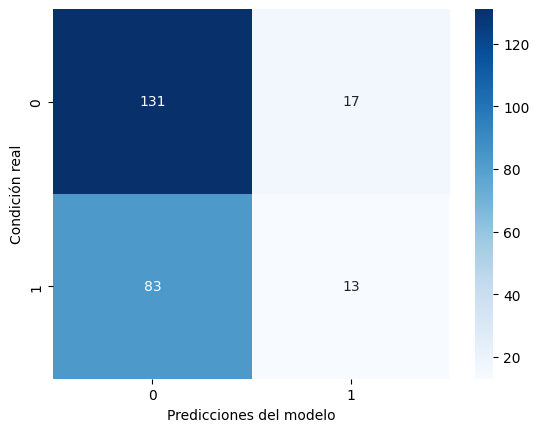

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.show()

Accuracy (Exactitud): indica la proporción de predicciones correctas sobre el total de predicciones realizadas. Aproximadamente el 68.4% de las predicciones hechas por el modelo son correctas.

F1 Score: es la media armónica de la precisión y el recall. Es útil cuando las clases están desequilibradas. Puede interpretarse como la precisión ajustada por el recall y viceversa. Un F1 score alto indica un buen equilibrio entre precisión y recall.

Precision: refiere a la proporción de predicciones positivas correctas sobre el total de predicciones positivas hechas por el modelo. El 77.5% de las veces el modelo predice correctamente AUTISTAS.

Recall (Exhaustividad o Sensibilidad):indica la proporción de observaciones positivas que fueron correctamente clasificadas. Es la verdadera positividad. El modelo identifica correctamente al 31% de los casos positivos.

<figure>
<center>
<img src='https://media.telefonicatech.com/telefonicatech/uploads/2021/1/121498_matriz.jpg' />
<figcaption>Image Caption</figcaption></center>
</figure>

### Análisis de componentes principales (PCA)

In [ ]:
# PCA es sensible a la escala
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

ss = StandardScaler()

normal_features = ss.fit_transform(features)
#X_train_std = scaler.fit_transform(X_train)
#X_test_std = scaler.fit_transform(X_test)

In [ ]:
features.head()

,0,1,2,3,4,5,6,7,8,9,...,4361,4362,4363,4364,4365,4366,4367,4368,4369,4370
0,0.884496,0.709854,0.759467,0.808396,0.748825,0.746855,0.797611,0.754630,0.699556,0.558432,...,0.759526,0.894507,0.848783,0.875080,0.853000,0.754495,0.673811,0.807199,0.812130,0.915447
1,0.913155,0.508644,0.210797,0.375724,0.136328,0.550674,0.217562,0.446146,0.257435,0.336017,...,0.491767,0.552078,0.645986,0.629501,0.814782,0.648253,0.585712,0.574145,0.465562,0.773946
2,0.693080,0.639012,0.427046,0.553249,0.370843,0.639087,0.615761,0.474038,0.523910,0.360967,...,0.510239,0.697781,0.573982,0.727019,0.648158,0.601135,0.471724,0.460433,0.525508,0.854126
3,0.674283,0.356046,0.395826,0.250278,0.315492,0.327619,0.418142,0.318003,0.344895,0.407478,...,0.608805,0.762027,0.589437,0.729525,0.827515,0.567599,0.546411,0.680090,0.719204,0.798524
4,0.631215,0.468764,0.447137,0.464821,0.383575,0.549706,0.380909,0.574176,0.417614,0.567322,...,0.546729,0.634173,0.671634,0.658479,0.599554,0.443173,0.456866,0.421308,0.572873,0.629786


In [ ]:
# esta bien normalizado? los valores me hacen ruido
print(normal_features)

[[ 1.12292510e+00  8.38364340e-01  1.24834494e+00 ...  1.91560132e+00
   1.82922839e+00  1.29690674e+00]
 [ 1.34503468e+00 -2.68203699e-01 -1.53928360e+00 ...  5.12301442e-01
  -2.92808572e-01  6.23890979e-02]
 [-3.60618691e-01  4.48766630e-01 -4.40585881e-01 ... -1.72405687e-01
   7.42414115e-02  7.61914593e-01]
 ...
 [ 1.00349483e-03  2.52111391e-01  1.05060112e+00 ... -3.90507347e-01
  -9.25888856e-02  3.64561711e-01]
 [-1.34938308e+00 -1.46436270e+00 -1.00749195e-01 ... -7.91025665e-01
  -7.49937371e-01 -9.41121318e-01]
 [ 4.24930786e-01 -5.56650280e-01  5.00432697e-01 ...  9.50793769e-01
   4.52333078e-01 -4.31626047e-01]]


In [ ]:
df_scaled = pd.DataFrame(data = normal_features)

In [ ]:
df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,4361,4362,4363,4364,4365,4366,4367,4368,4369,4370
0,1.122925,0.838364,1.248345,1.386660,1.286343,0.982025,1.447683,1.256291,1.178049,0.737485,...,1.917144,2.234018,1.676896,1.494793,1.403467,1.439991,1.303360,1.915601,1.829228,1.296907
1,1.345035,-0.268204,-1.539284,-1.021335,-1.838079,-0.254219,-1.694549,-0.341922,-0.985900,-0.358903,...,0.343322,0.026837,0.345681,-0.341474,1.168263,0.800843,0.784654,0.512301,-0.292809,0.062389
2,-0.360619,0.448767,-0.440586,-0.033336,-0.641790,0.302922,0.462570,-0.197420,0.318355,-0.235915,...,0.451895,0.965987,-0.126978,0.387695,0.142814,0.517380,0.113528,-0.172406,0.074241,0.761915
3,-0.506302,-1.107426,-0.599209,-1.719486,-0.924142,-1.659817,-0.607968,-1.005814,-0.557831,-0.006637,...,1.031243,1.380093,-0.025522,0.406434,1.246626,0.315632,0.553262,1.150233,1.260245,0.276818
4,-0.840086,-0.487523,-0.338510,-0.525470,-0.576844,-0.260323,-0.809667,0.321384,-0.201909,0.781312,...,0.666372,0.555992,0.514039,-0.124801,-0.156308,-0.432914,0.026049,-0.407991,0.364258,-1.195326


PCA con 77 componentes

In [ ]:
pca = PCA(n_components= 77, random_state=42)

In [ ]:
pca_trans = pca.fit_transform(df_scaled)

In [ ]:
print('Features originales - shape:', features.shape)
print('Features PCA - shape:', pca_trans.shape)
print(pca_trans)

Features originales - shape: (973, 4371)
Features PCA - shape: (973, 77)
[[ 68.34726829 -11.79744575  -1.58290061 ...  -0.12541748   1.13780717
    0.1457752 ]
 [  4.63758931   5.63729645  -7.63262643 ...  -0.11803745   2.04616956
   -2.44281343]
 [-11.28041949  -8.89838261  -4.8645195  ...  -0.11952444  -3.54934182
    4.25015519]
 ...
 [ 11.41646434 -15.8538859    1.77629839 ...   2.37028605   2.31050673
    0.830955  ]
 [-30.19551599 -12.7338051    2.89098247 ...   0.3248906   -3.91099917
   -1.00864566]
 [-22.46403531   6.22090067 -12.2054376  ...   5.77923479   1.80847516
    4.00486491]]


In [ ]:
prop_var = pca.explained_variance_ratio_ # extrae la proporcion de la varianza explicada
print(prop_var)

[0.41130373 0.02928851 0.02679511 0.01950473 0.01878734 0.01510755
 0.01317895 0.01228843 0.01131914 0.01066543 0.0090498  0.0081717
 0.00812681 0.00731692 0.00710645 0.00695748 0.00625637 0.00589468
 0.00579131 0.00550153 0.00510483 0.00495211 0.00480598 0.00465463
 0.00441224 0.00430531 0.00404019 0.00387114 0.00371989 0.00367701
 0.00356098 0.00346488 0.00337513 0.00331641 0.00323152 0.00315557
 0.00305236 0.00296633 0.002914   0.00287465 0.0028166  0.0027724
 0.0026896  0.00265129 0.00258697 0.00255166 0.00248445 0.00245259
 0.00237938 0.00236428 0.0023041  0.00223663 0.00222465 0.00218887
 0.00216494 0.00209047 0.00206401 0.00202473 0.00197127 0.00193441
 0.00192136 0.0018843  0.00188108 0.00181012 0.0017944  0.00176572
 0.00173779 0.00171807 0.00167747 0.0016554  0.00164142 0.00162577
 0.0016098  0.00158779 0.00153023 0.00150185 0.00148722]


In [ ]:
PC_number = np.arange(pca.n_components_) + 1 # enumera los números de los componentes
print(PC_number)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77]


<function matplotlib.pyplot.show(close=None, block=None)>

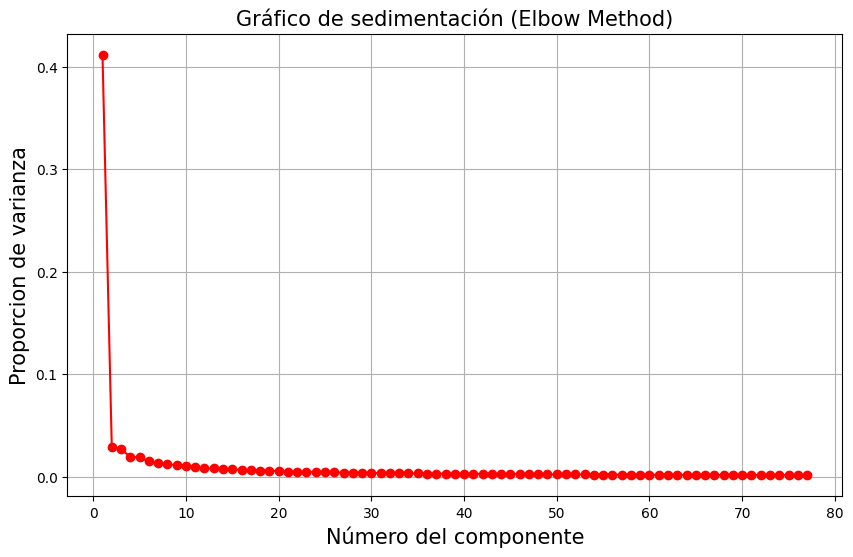

In [ ]:
# Gráfico de sedimentación

plt.figure(figsize=(10,6))
plt.plot(PC_number,
         prop_var,
         'ro-')

plt.title('Gráfico de sedimentación (Elbow Method)',
          fontsize=15)
plt.xlabel('Número del componente',
           fontsize=15)
plt.ylabel('Proporcion de varianza',
           fontsize=15)

plt.grid()
plt.show

In [ ]:
# @title
# Kaiser Rule
var = pca.explained_variance_

<function matplotlib.pyplot.show(close=None, block=None)>

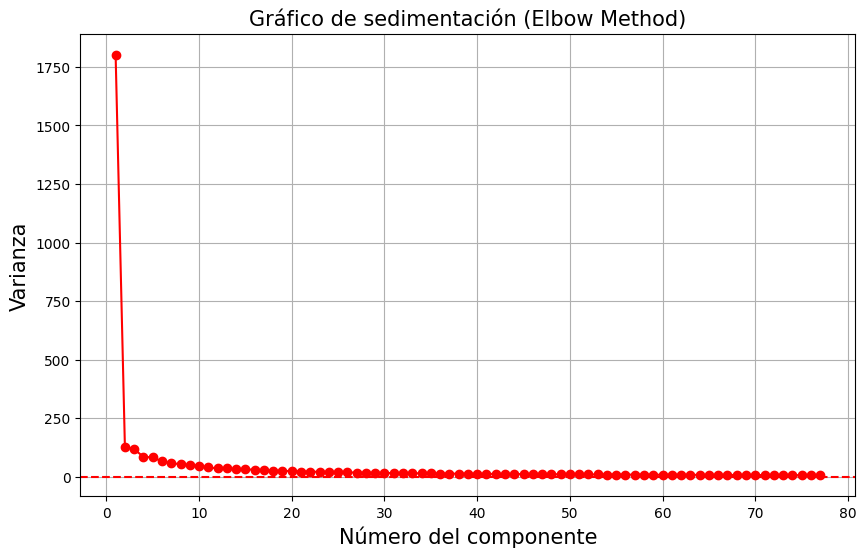

In [ ]:
# @title
# Gráfico de sedimentación x Kaiser RUle

plt.figure(figsize=(10,6))
plt.plot(PC_number,
         var,
         'ro-')

plt.title('Gráfico de sedimentación (Elbow Method)',
          fontsize=15)
plt.xlabel('Número del componente',
           fontsize=15)
plt.ylabel('Varianza',
           fontsize=15)
plt.axhline(y=1,
            color = 'r',
            linestyle = '--')


plt.grid()
plt.show

PCA con 2 componentes

In [ ]:
# corro PCA con 2 componentes

pca = PCA(n_components = 2)
PC = pca.fit_transform(df_scaled)
print(PC)
print(PC.shape)

# Los componentes principales PC son combinaciones lineales de las variables originales

[[ 68.34726829 -11.79736848]
 [  4.63758931   5.6368971 ]
 [-11.28041949  -8.8983943 ]
 ...
 [ 11.41646434 -15.85391064]
 [-30.19551599 -12.73365576]
 [-22.46403531   6.22055696]]
(973, 2)


In [ ]:
# biplot data
# extraigo ambos componentes
PC1= PC[:,0]
PC2 = PC[:,1]

In [ ]:
loadings = pca.components_ # explica la asociacion entre los componentes y las variables originales

# loadings son los coeficientes que indican la relacion entre las variables originales y los componentes principales
# multiplican cada variable original en la combinacion lineal que forma cada componente principal
print(loadings)
print(loadings.shape)

# hay dos rows representando cada componente, y las 4371 variables originales

[[0.01384749 0.01578702 0.01684336 ... 0.01042089 0.00995147 0.0120216 ]
 [0.01551885 0.0220547  0.02039035 ... 0.01468796 0.02181827 0.01102528]]
(2, 4371)


In [ ]:
scalePC1 = 1.0/(PC1.max()-PC1.min())
print(scalePC1)

scalePC2 = 1.0/(PC2.max()-PC2.min())
print(scalePC2)


0.004269280002383269
0.014086164503730646


In [ ]:
cond = df['condicion']

In [ ]:
print(loadings)

[[0.01384749 0.01578702 0.01684336 ... 0.01042089 0.00995147 0.0120216 ]
 [0.01551815 0.02205481 0.02038979 ... 0.01468787 0.02181873 0.01102364]]


In [ ]:
np.save('/content/drive/MyDrive/Favaloro/Tesis/PC.npy', PC)
np.save('/content/drive/MyDrive/Favaloro/Tesis/loadings.npy', loadings)

In [ ]:
PC = np.load('/content/drive/MyDrive/Favaloro/Tesis/PC.npy')
loadings = np.load('/content/drive/MyDrive/Favaloro/Tesis/loadings.npy')

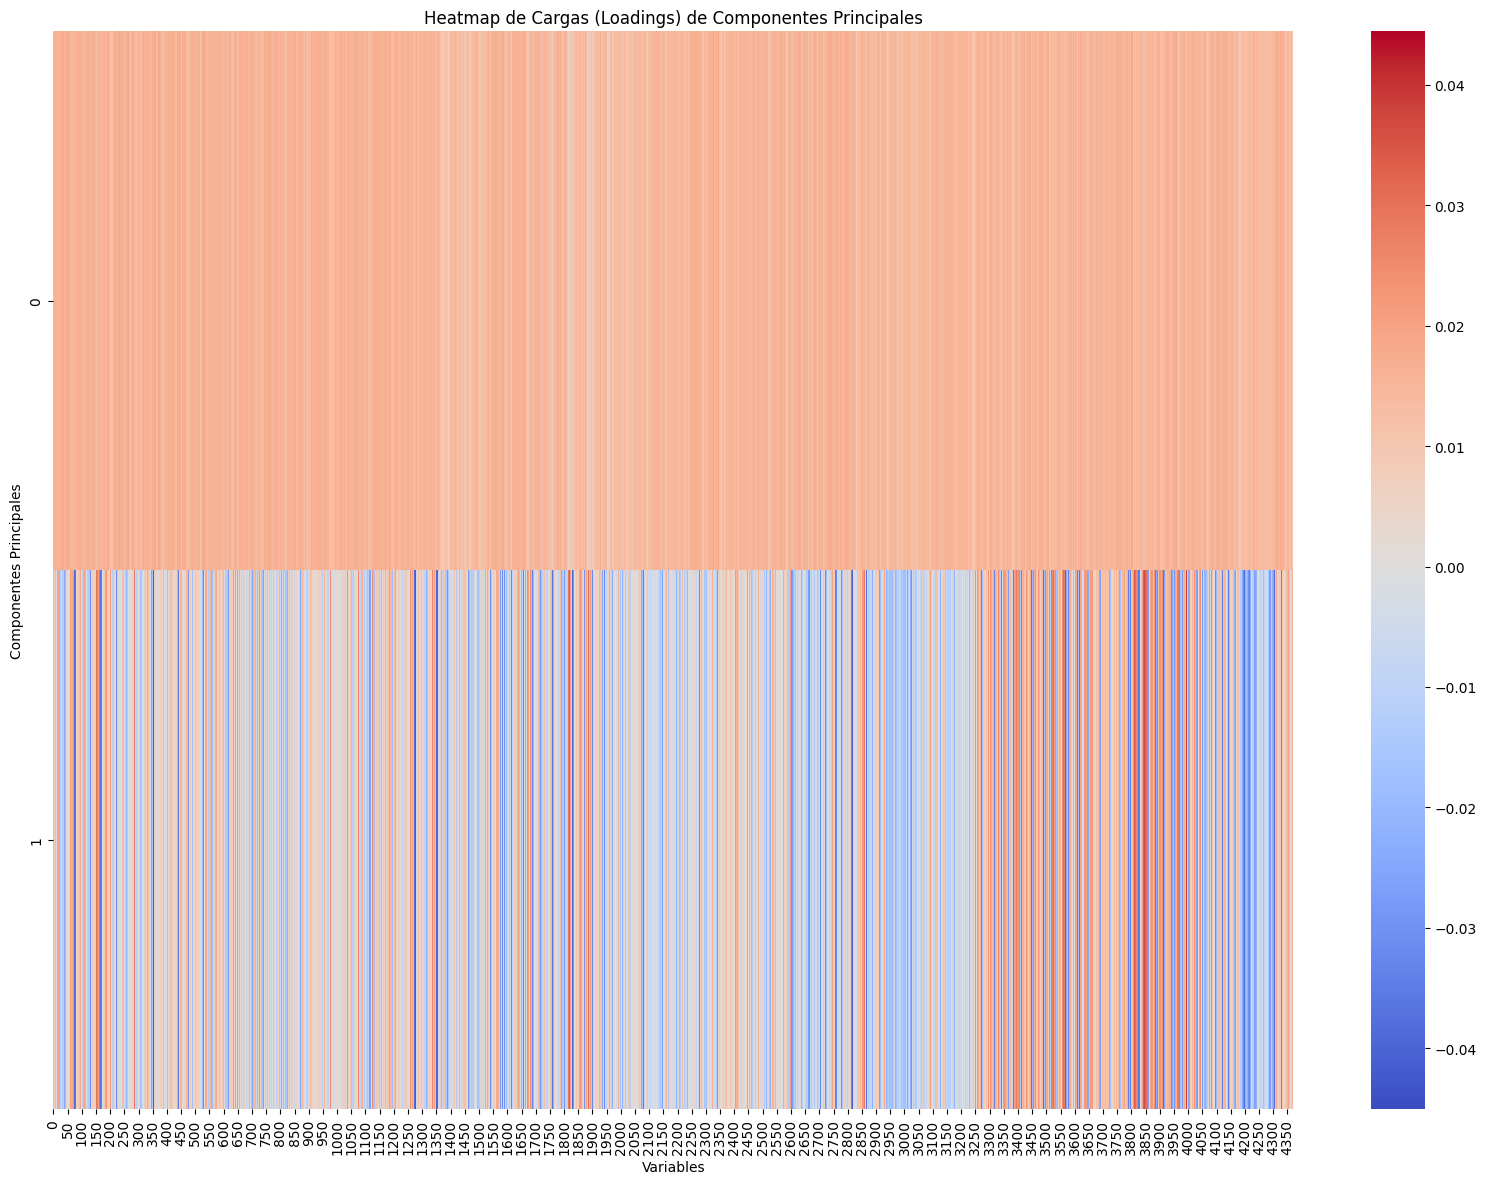

In [ ]:
# @title
# heatmat de las loadings (cargas)
plt.figure(figsize=(20, 14))
sns.heatmap(loadings,
            #annot=True,
            cmap='coolwarm')
plt.title('Heatmap de Cargas (Loadings) de Componentes Principales')
plt.xlabel('Variables')
plt.ylabel('Componentes Principales')
plt.show()


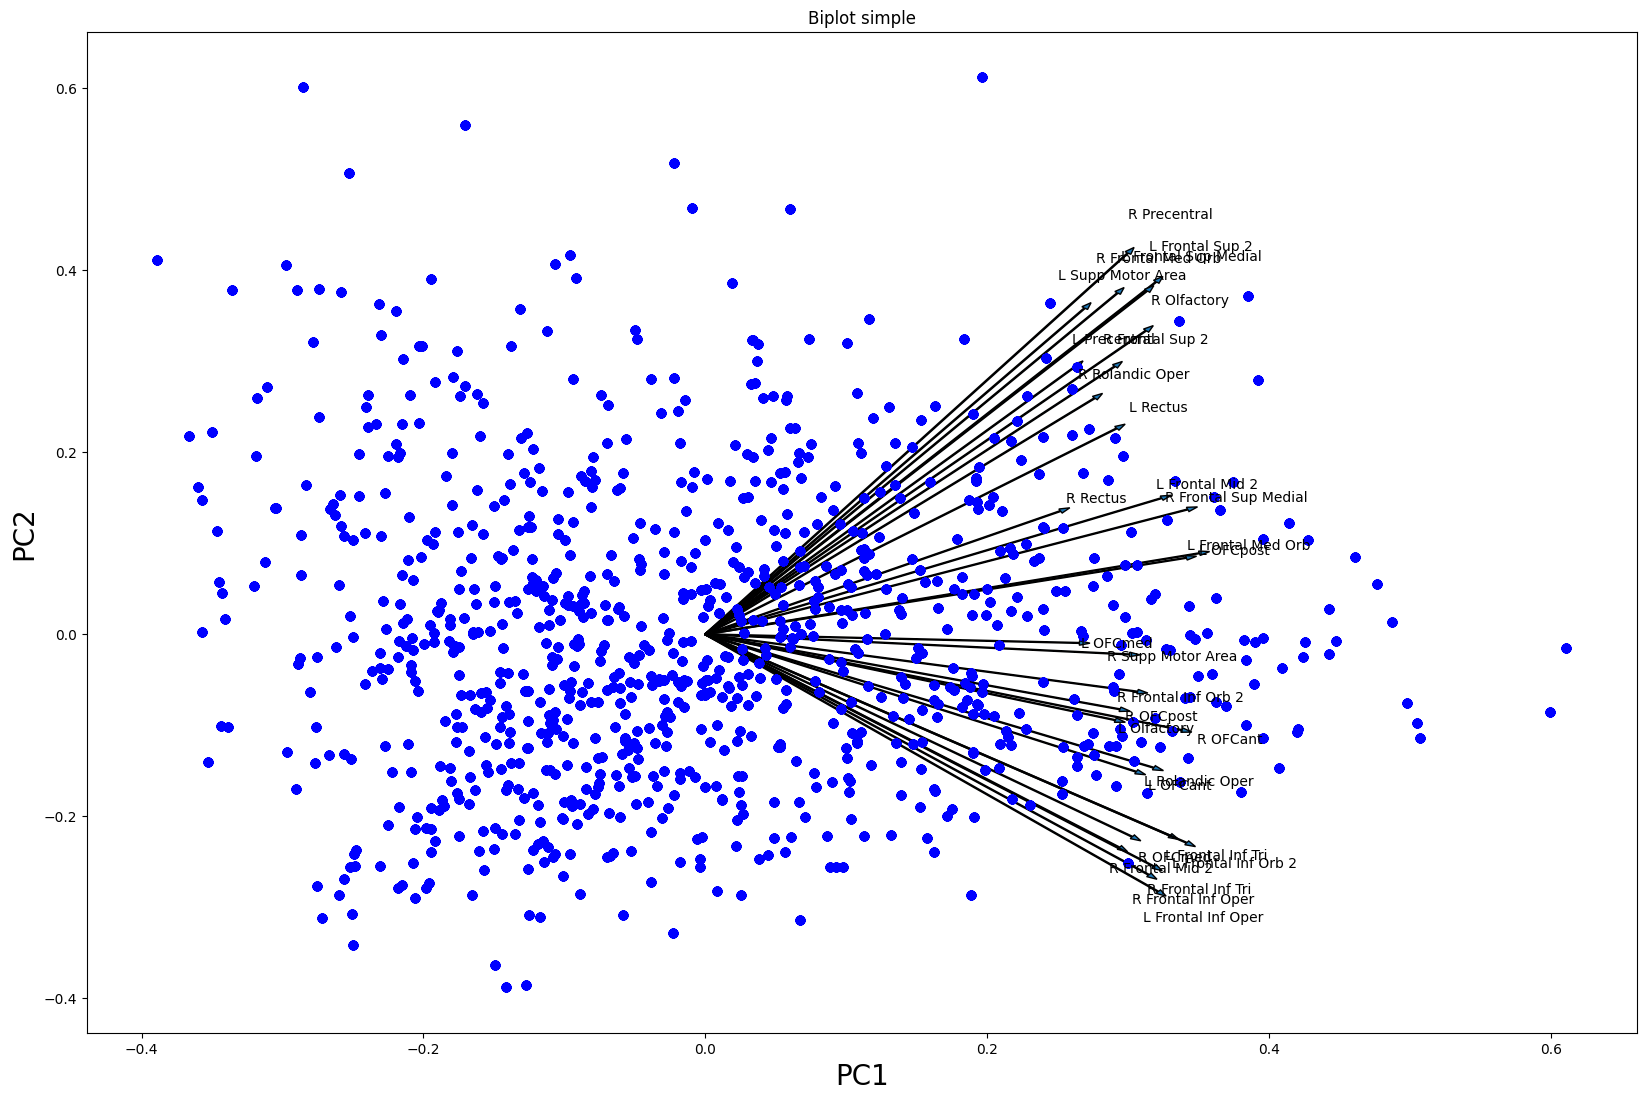

In [ ]:
# @title
# https://statisticsglobe.com/biplot-pca-explained

# simple biplot

fig,ax = plt.subplots(figsize=(20,13))

arrow_scale = 19


for i, roi in enumerate(rois[:30]): # itero por las distintas variables (rois)
  ax.arrow(0,   #plot arrows
           0,
           loadings[0,i] * arrow_scale,
           loadings[1,i] * arrow_scale,
           #width = 0.0001,
           head_width = 0.005,
           #head_length = 0.5,
           #length_includes_head = 7,
           #color='grey',
           #linewidth = 1.0,
          # head_starts_at_zero = True
           #shape= 'left'
           )
  ax.text(loadings[0, i] * arrow_scale * 1.1,
          loadings[1, i] * arrow_scale * 1.1,
          roi,
          fontsize=10, ha='center', va='center')

  ax.scatter(PC1 * scalePC1,
             PC2 * scalePC2,
             color='Blue')
  ax.set_xlabel('PC1',
                fontsize = 20)
  ax.set_ylabel('PC2',
                fontsize = 20)
  ax.set_title('Biplot simple')

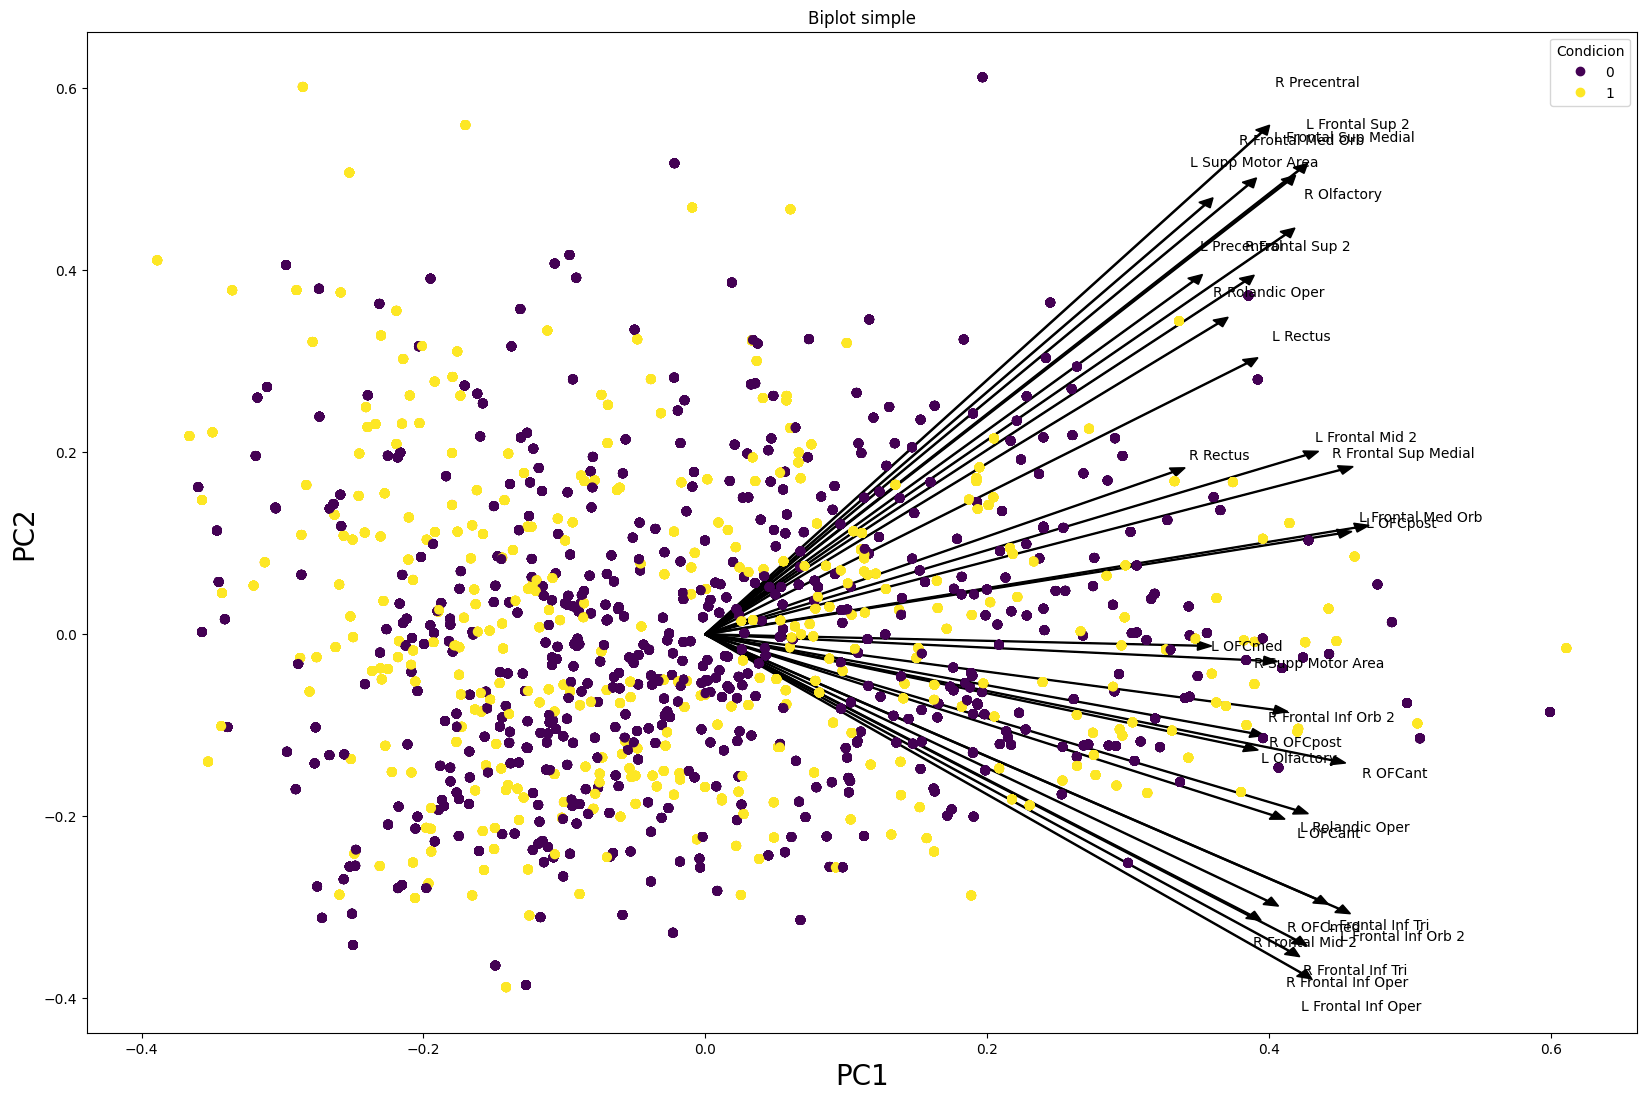

In [ ]:
# @title
# Biplot x condicion

fig,ax = plt.subplots(figsize=(20,13))

arrow_scale = 25


for i, roi in enumerate(rois[:30]): # itero por las distintas variables (rois)
  ax.arrow(0,   #plot arrows
           0,
           loadings[0,i] * arrow_scale,
           loadings[1,i] * arrow_scale,
           #width = 0.0001,
           head_width = 0.01,
           head_length = 0.01,
           #length_includes_head = 7,
           color='black',
           #linewidth = 1.0,
          # head_starts_at_zero = True
           #shape= 'left'
           )
  ax.text(loadings[0, i] * arrow_scale * 1.1,
          loadings[1, i] * arrow_scale * 1.1,
          roi,
          fontsize=10, ha='center', va='center')

  scatter = ax.scatter(PC1 * scalePC1, PC2 * scalePC2, c = cond, cmap='viridis')
  ax.set_xlabel('PC1',
                fontsize = 20)
  ax.set_ylabel('PC2',
                fontsize = 20)
  ax.set_title('Biplot simple')
  ax.legend(*scatter.legend_elements(),
            loc = "upper right",
            title = "Condicion")

In [ ]:

df_pc = pd.DataFrame(data = PC,
                      columns = ['PC1', 'PC2' ])
df_pc['group'] = df['condicion']
df_pc.head()

,PC1,PC2,group
0,68.347268,-11.797631,1
1,4.637589,5.637387,0
2,-11.280419,-8.898855,1
3,0.149551,-3.570022,0
4,-9.513558,-13.106227,0


In [ ]:
np.save('/content/drive/MyDrive/Favaloro/Tesis/df_pc.csv', df_pc)

In [ ]:
PC = np.load('/content/drive/MyDrive/Favaloro/Tesis/PC.npy')

In [ ]:
# Controles = cero: 0
# Autistas = uno: 1

cont_PC1 = df_pc.loc[df_pc['group']== 0, 'PC1']
cont_PC2 = df_pc.loc[df_pc['group']== 0, 'PC2']

aut_PC1 = df_pc.loc[df_pc['group'] == 1, 'PC1']
aut_PC2 = df_pc.loc[df_pc['group'] == 1, 'PC2']

In [ ]:
# escalar la data nueva

scale_PC1_cont = 1.0/(cont_PC1.max() - cont_PC1.min())
scale_PC2_cont = 1.0/(cont_PC2.max() - cont_PC2.min())

scale_PC1_aut = 1.0/(aut_PC1.max() - aut_PC1.min())
scale_PC2_aut = 1.0/(aut_PC2.max() - aut_PC2.min())

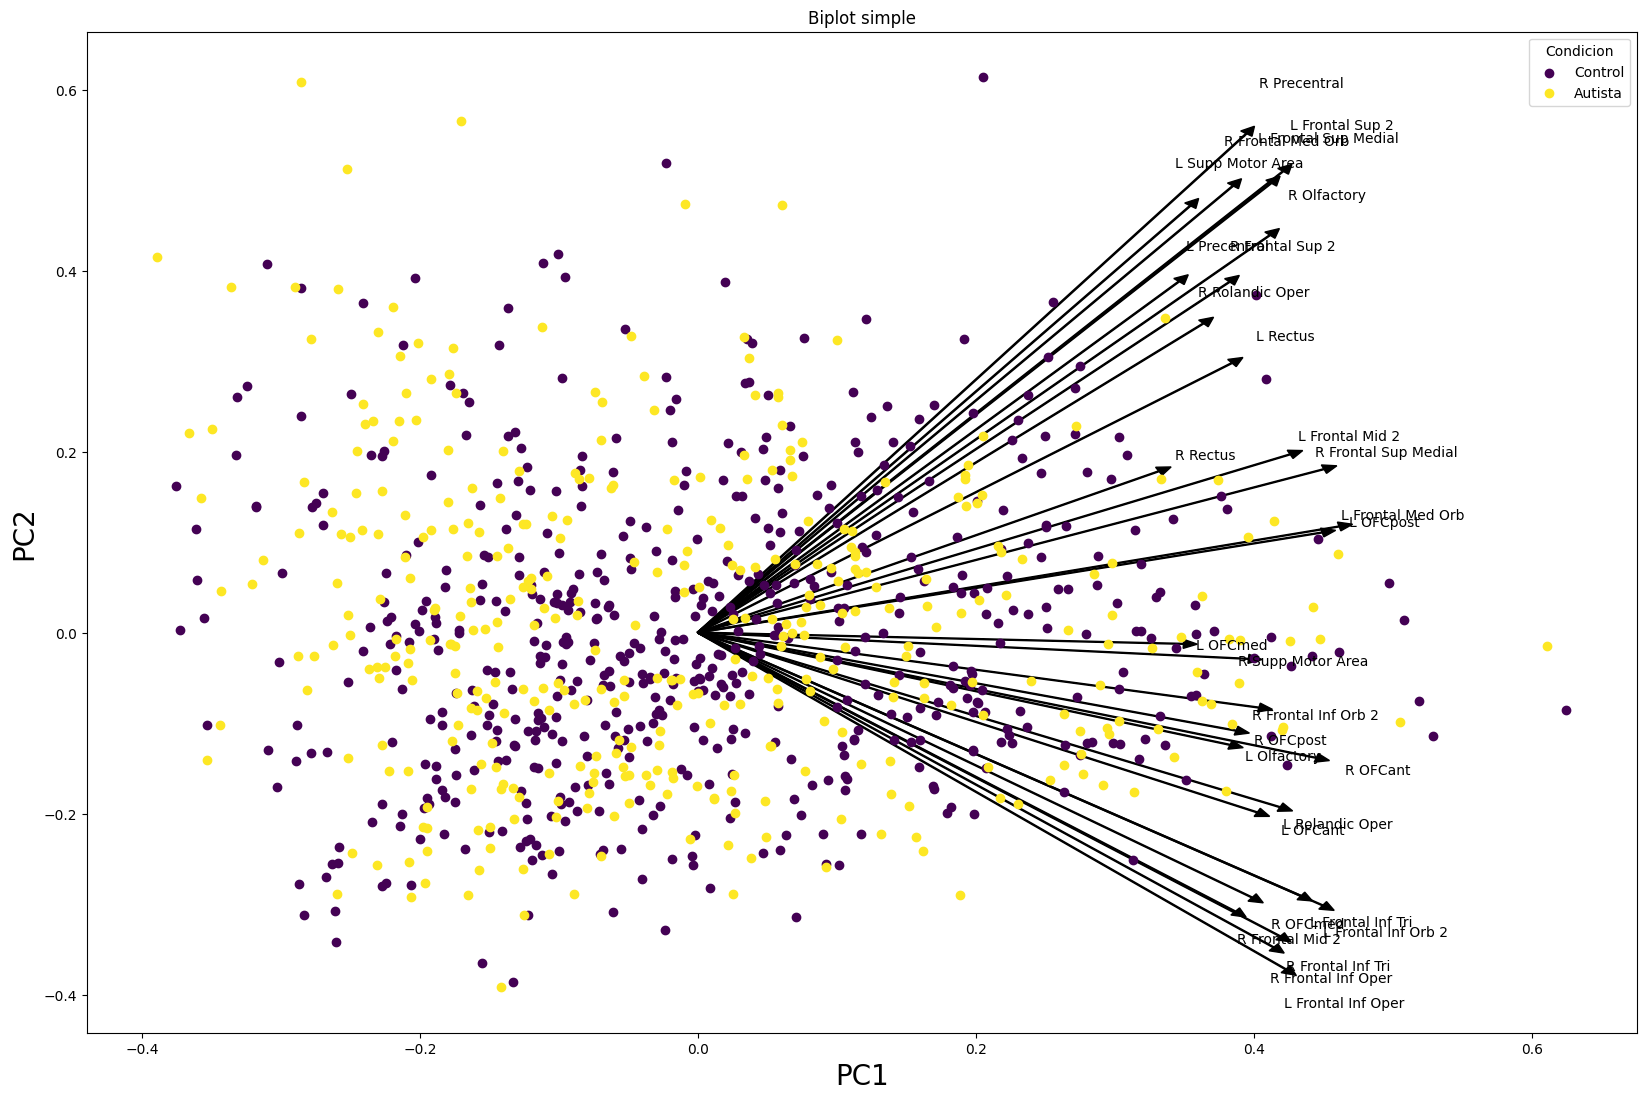

In [ ]:
# Biplot x condicion

fig,ax = plt.subplots(figsize=(20,13))

arrow_scale = 25


for i, roi in enumerate(rois[:30]): # itero por las distintas variables (rois)
  ax.arrow(0,   #plot arrows
           0,
           loadings[0,i] * arrow_scale,
           loadings[1,i] * arrow_scale,
           #width = 0.0001,
           head_width = 0.01,
           head_length = 0.01,
           #length_includes_head = 7,
           color='black',
           #linewidth = 1.0,
          # head_starts_at_zero = True
           #shape= 'left'
           )
  ax.text(loadings[0, i] * arrow_scale * 1.1,
          loadings[1, i] * arrow_scale * 1.1,
          roi,
          fontsize=10, ha='center', va='center')

scatter = ax.scatter(cont_PC1 * scale_PC1_cont,
                       cont_PC2 * scale_PC2_cont,
                       c="#440154",
                       label = 'Control')

scatter = ax.scatter(aut_PC1 * scale_PC1_aut,
                       aut_PC2 * scale_PC2_aut,
                       c="#FDE724",
                       label = 'Autista')


ax.set_xlabel('PC1',
                fontsize = 20)
ax.set_ylabel('PC2',
                fontsize = 20)
ax.set_title('Biplot simple')

leyenda = ax.legend(loc = "upper right",title = "Condicion")

# Clasificadores con componentes principales

In [ ]:
df_pc = pd.read_csv('/content/drive/MyDrive/Favaloro/Tesis/df_pc.csv')

In [ ]:
df_pc.head()

,PC1,PC2,group
0,68.347268,-11.797539,1
1,4.637589,5.636807,0
2,-11.280419,-8.898439,1
3,0.149551,-3.570228,0
4,-9.513558,-13.106316,0


In [ ]:
from sklearn.model_selection import train_test_split

X = df_pc.drop(['group'], axis=1)
y = df_pc['group'].values
y.shape

(973,)

In [ ]:
# División de los datos en conjuntos de entrenamiento y prueba con PC

X_train_PC, X_test_PC, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.25)
# Stratify balancea la cantidad de sujetos de cada condicion en la división de os datos

print(f'X_train: {X_train_PC.shape}')
print(f'X_test: {X_test_PC.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (729, 2)
X_test: (244, 2)
y_train: (729,)
y_test: (244,)


**Máquinas de Vectores de Soporte con Componentes Principales**

In [ ]:
# Define the hyperparameter grid to explore
#param_grid = {'C': [0.0001, 0.1, 1, 10,100], 'degree': [1,2,3,5,8,10], 'gamma': ['auto','scale'],'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
param_grid = {'C': [0.1, 1], 'degree': [3,5], 'gamma': ['scale'],'kernel': ['poly']}

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
svm = SVC()


# hyp tunning con gridsearch
grid_search = GridSearchCV(svm, param_grid, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train_PC, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_PC)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True)


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'Model': SVC(C=1, degree=5, kernel='poly'), 'Best Params': {'C': 1, 'degree': 5, 'gamma': 'scale', 'kernel': 'poly'}, 'Accuracy': 0.6172791686348607, 'Classification Report': {'AUT': {'precision': 0.6049382716049383, 'recall': 0.9932432432432432, 'f1-score': 0.751918158567775, 'support': 148}, 'CONT': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 96}, 'accuracy': 0.6024590163934426, 'macro avg': {'precision': 0.30246913580246915, 'recall': 0.4966216216216216, 'f1-score': 0.3759590792838875, 'support': 244}, 'weighted avg': {'precision': 0.366929771301356, 'recall': 0.6024590163934426, 'f1-score': 0.45608150601651926, 'support': 244}}}


[[147   1]
 [ 96   0]]


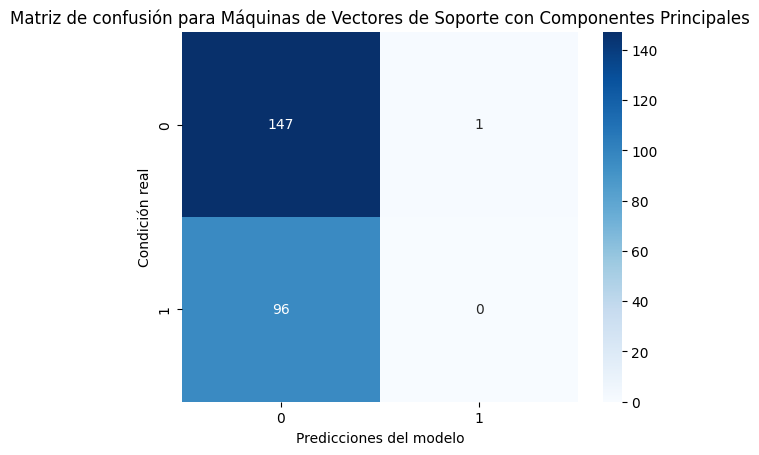

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.title('Matriz de confusión para Máquinas de Vectores de Soporte con Componentes Principales')
plt.show()

**Bósques Aleatorios con Componentes Principales**

In [ ]:
param_grid_RF = {'n_estimators': [1000], 'max_depth': [5,20,None] }

In [ ]:
y_train = y_train.astype(float)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

RF = RandomForestClassifier()

# hyp tunning con gridsearch
grid_search = GridSearchCV(RF, param_grid_RF, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train_PC, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_PC)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True) # la función usa las etiquetas de clase reales (0 y 1) para calcular las métricas, y el parámetro target_names solo se usa con fines de visualización.


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
#resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
#resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
{'Model': RandomForestClassifier(max_depth=5, n_estimators=1000), 'Best Params': {'max_depth': 5, 'n_estimators': 1000}, 'Accuracy': 0.6049220595181861, 'Classification Report': {'AUT': {'precision': 0.6066350710900474, 'recall': 0.8648648648648649, 'f1-score': 0.7130919220055711, 'support': 148}, 'CONT': {'precision': 0.3939393939393939, 'recall': 0.13541666666666666, 'f1-score': 0.20155038759689922, 'support': 96}, 'accuracy': 0.5778688524590164, 'macro avg': {'precision': 0.5002872325147207, 'recall': 0.5001407657657658, 'f1-score': 0.4573211548012352, 'support': 244}, 'weighted avg': {'precision': 0.5229515259815936, 'recall': 0.5778688524590164, 'f1-score': 0.5118296789595362, 'support': 244}}}


[[128  20]
 [ 83  13]]


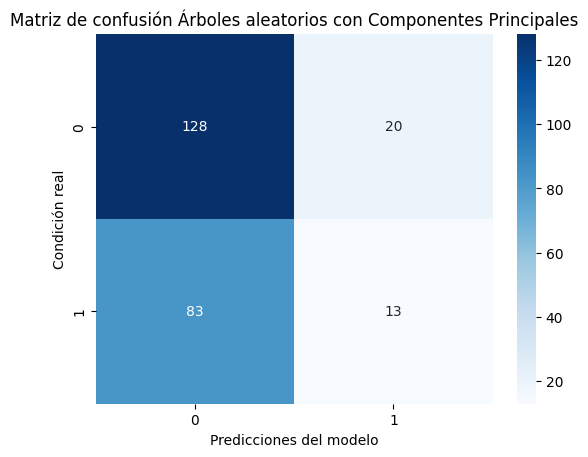

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.title('Matriz de confusión Árboles aleatorios con Componentes Principales')
plt.show()

**Regresión logística con Componentes Principales**

In [ ]:
# Define the hyperparameter grid to explore
param_grid_LR = {'C': [0.0001, 0.1, 1, 10,100],'max_iter': [1000, 2000], 'solver' : ['newton-cg', 'lbfgs', 'liblinear'], 'penalty' : [None, 'l1','l2']}

In [ ]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()


# hyp tunning con gridsearch
grid_search = GridSearchCV(LR, param_grid_LR, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train_PC, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_PC)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True)


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'Model': LogisticRegression(C=0.0001, max_iter=1000, solver='newton-cg'), 'Best Params': {'C': 0.0001, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'newton-cg'}, 'Accuracy': 0.6117997165800662, 'Classification Report': {'AUT': {'precision': 0.6090534979423868, 'recall': 1.0, 'f1-score': 0.7570332480818415, 'support': 148}, 'CONT': {'precision': 1.0, 'recall': 0.010416666666666666, 'f1-score': 0.020618556701030924, 'support': 96}, 'accuracy': 0.610655737704918, 'macro avg': {'precision': 0.8045267489711934, 'recall': 0.5052083333333334, 'f1-score': 0.3888259023914362, 'support': 244}, 'weighted avg': {'precision': 0.7628685151453822, 'recall': 0.610655737704918, 'f1-score': 0.467296320325457, 'support': 244}}}


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
150 fits failed out of a total of 450.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1216, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 1223, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(mul

[[148   0]
 [ 95   1]]


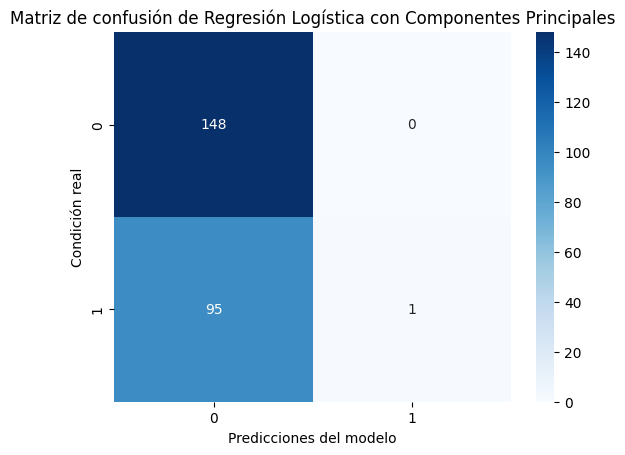

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.title('Matriz de confusión de Regresión Logística con Componentes Principales')
plt.show()

**Árboles de Decisión con Componentes Principales**

In [ ]:
param_grid_DT = {'splitter' : ['best', 'random'], 'criterion': ['gini', 'entropy', 'log_loss'], 'max_depth':  [None,1,3,5], 'min_samples_split':  [2,3,7,10], 'min_samples_leaf':  [1,2,5,8]}

In [ ]:
from sklearn.tree import DecisionTreeClassifier
DTC =  DecisionTreeClassifier()


# hyp tunning con gridsearch
grid_search = GridSearchCV(DTC, param_grid_DT, scoring='accuracy' , n_jobs=-1, verbose=1)
grid_search.fit(X_train_PC, y_train)


best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_PC)
report = classification_report(y_test, y_pred, target_names=['AUT', 'CONT'], output_dict=True)


result = {'Model': best_model,'Best Params': grid_search.best_params_,'Accuracy': grid_search.best_score_,'Classification Report': report}


# Resultados
resultados_df = pd.DataFrame(result)
#resultados_df.to_csv('resultados.csv', index=False)
resultados_df.to_excel('resultados.xlsx', index=False)


# Print the classification report
print(result)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
{'Model': DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=8,
                       splitter='random'), 'Best Params': {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 8, 'min_samples_split': 2, 'splitter': 'random'}, 'Accuracy': 0.6336986301369862, 'Classification Report': {'AUT': {'precision': 0.6136363636363636, 'recall': 0.9121621621621622, 'f1-score': 0.7336956521739131, 'support': 148}, 'CONT': {'precision': 0.4583333333333333, 'recall': 0.11458333333333333, 'f1-score': 0.18333333333333332, 'support': 96}, 'accuracy': 0.5983606557377049, 'macro avg': {'precision': 0.5359848484848485, 'recall': 0.5133727477477478, 'f1-score': 0.4585144927536232, 'support': 244}, 'weighted avg': {'precision': 0.5525335320417287, 'recall': 0.5983606557377049, 'f1-score': 0.5171596578759801, 'support': 244}}}


[[135  13]
 [ 85  11]]


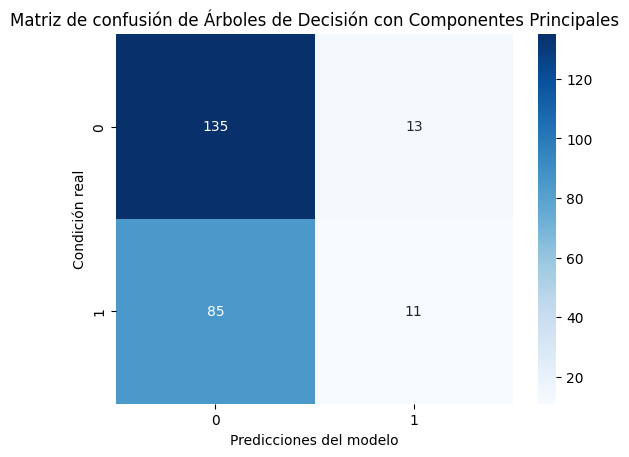

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
print(conf_mat)
sns.heatmap(conf_mat, annot = True, fmt = 'd', cmap= 'Blues')
plt.xlabel('Predicciones del modelo')
plt.ylabel('Condición real')
plt.title('Matriz de confusión de Árboles de Decisión con Componentes Principales')
plt.show()